# Vertical multi-omics integration - analysis of matched datasets 

<!-- In this notebook we will perform exploratory analysis and joint dimensionality reduction on matched scRNA-seq and scATAC-seq data of developing brain cortex from [Trevino et al.2021](https://www.cell.com/cell/fulltext/S0092-8674(21)00942-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867421009429%3Fshowall%3Dtrue), focusing on differentiation of excitatory glutamatergic neurons.

What we will cover:

1. Construction of objects for multi-modal data handling using [muon]()
2. Joint exploratory data analysis
3. Dimensionality reduction with multi-view models ("vertical" integration) using [Multi-Omics Factor Analysis]() and [Weighted Nearest-Neighbor graphs]()
4. Basics of feature-wise analysis

What we _won't_ cover:

1. Methods for aggregation of expression and accessibility profiles from single-cells for inference of regulatory links (see [SEAcells]()) -->


In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy

import muon as mu
import anndata

import pyranges

## Plotting utils
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

/home/jovyan/my-conda-envs/sc2022-multiomics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
## Set plotting parameters for scanpy
sc.set_figure_params(figsize=[9,9], color_map = 'viridis_r')

<!-- <div class="alert alert-block alert-info"> 
    
    <b>New to python?</b> Don't panic! Use [help] to 
    
</div>
 -->

## Load single-omic data

The data for each omic view is stored in [`AnnData`](https://anndata.readthedocs.io/en/latest/index.html) format. An `AnnData` object allows us to store a matrix and add annotations to its different dimensions, defined as “observations” (i.e. cells), and measured “variables” (i.e. genes for the RNA view and peaks for the ATAC view). See [this tutorial](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html) for a quick-start on the structure of AnnData objects.

We downloaded the original datasets following the instructions in https://github.com/GreenleafLab/brainchromatin, which we further cleaned, filtered and  converted to `AnnData` objects saved in `.h5ad` files. Pre-processing and dimensionality reduction for the individual modalities is shown in [this notebook]().

In [108]:
## Put the path to the data here
# # from AWS instance
# data_dir = "/data/multiomics/gr2_matched_vertical"
## or
# data_dir = "/path/to/data/gr2_matched_vertical"
data_dir = "/home/jovyan/mount/gdrive/sc-multiomics-course-2022/gr2_matched_vertical/"

In [109]:
rna_adata = sc.read_h5ad('{d}/Trevino_multiome_RNA_clean.preprocessed.h5ad'.format(d=data_dir))
atac_adata = sc.read_h5ad('{d}/Trevino_multiome_ATAC_clean.preprocessed.h5ad'.format(d=data_dir))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


We can access the annotations on cells using `adata.obs` (cell type annotations are stored in `adata.obs["cluster_name"]`, while cells that belong to the glutamatergic neuron differentiation trajectory are marked in `adata.obs['in_GluN_trajectory']`)

In [114]:
atac_adata.obs

Sample_ID Sample_Age  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC  hft_ctx_w21_dc1r3_r1      pcw21   
...                                                     ...        ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA  hft_ctx_w21_dc2r2_r2      pcw21   

                                      Sample_Batch      Cell_Barcode  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA     b2020_11  AAACAGCCAGCAATAA   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA     b2020_11  AAACAGCCAGCTCATA   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA     b2020_11  AAACATGCACGTTACA   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT     b2020_11  AAACATGCATAAACCT   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC     b2020_11  AAACATGCATTTAAGC   
...                                            ...               ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG     b2020_11  TTTGGTGCATGAATAG   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG     b2020_11  TTTGTCCCAGTTTACG   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA     b2020_11  TTTGTCTAGTGAGCAA   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG     b2020_11  TTTGTGAAGACAGGCG   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA     b2020_11  TTTGTGTTCGTCCTTA   

                                      Dissociation_ID          Assay  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA               A  Multiome_ATAC   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA               A  Multiome_ATAC   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA               A  Multiome_ATAC   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT               A  Multiome_ATAC   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC               A  Multiome_ATAC   
...                                               ...            ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG               B  Multiome_ATAC   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG               B  Multiome_ATAC   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA               B  Multiome_ATAC   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG               B  Multiome_ATAC   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA               B  Multiome_ATAC   

                                          LSI_f1     LSI_f2  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA  -9.772574  21.350702   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA  16.989109   6.703968   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA  -5.891555 -13.836912   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT  29.148956  17.428812   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC  24.736876  16.473536   
...                                          ...        ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG  17.528111  13.406154   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG  19.121567  14.246389   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA  24.490839   8.238097   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG  -9.573349  -1.466923   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA  -2.562073  15.052531   

                                       n_genes_by_counts  total_counts leiden  
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA               4844  16900.980469      9  
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA               7307  18248.400391      5  
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA               8805  19389.804688      8  
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT              11378  21158.382812      3  
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC              10662  20530.521484      3  
...                                                  ...           ...    ...  
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG               3135  11123.648438      3  
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTT

We can access the annotation on features (genes for RNA modality, peaks for ATAC modality) with `adata.var`. Here we also store the genomic coordinates of the peaks, which we will use later.

In [115]:
rna_adata.var

gene_id             gene_type   gene_name  n_cells  \
AL627309.1  ENSG00000238009.6               lincRNA  AL627309.1       41   
AL627309.5  ENSG00000241860.6  processed_transcript  AL627309.5       77   
AL669831.2  ENSG00000229905.1         antisense_RNA  AL669831.2        4   
AL669831.5  ENSG00000237491.8               lincRNA  AL669831.5      593   
FAM87B      ENSG00000177757.2               lincRNA      FAM87B        6   
...                       ...                   ...         ...      ...   
MT-ND4L     ENSG00000212907.2        protein_coding     MT-ND4L     4748   
MT-ND4      ENSG00000198886.2        protein_coding      MT-ND4     8286   
MT-ND5      ENSG00000198786.2        protein_coding      MT-ND5     6744   
MT-ND6      ENSG00000198695.2        protein_coding      MT-ND6     1939   
MT-CYB      ENSG00000198727.2        protein_coding      MT-CYB     8282   

            highly_variable     means  dispersions  dispersions_norm  
AL627309.1            False  0.082113     3.224278         -0.358397  
AL627309.5            False  0.137769     3.185355         -0.458135  
AL669831.2            False  0.008042     3.265629         -0.252438  
AL669831.5            False  0.912602     3.528598         -0.295463  
FAM87B                 True  0.016905     3.909067          1.396342  
...                     ...       ...          ...               ...  
MT-ND4L               False  3.022517     3.464332         -1.226362  
MT-ND4                False  5.501800     4.778122         -0.744001  
MT-ND5                False  4.066192     3.993302         -0.297075  
MT-ND6                False  1.737467     3.249987         -1.541235  
MT-CYB                False  5.516113     4.911272         -0.508697  

[26572 rows x 8 columns]

In [116]:
atac_adata.var

seqnames     start       end  width strand             name  n_cells  \
0          chr1    180451    180951    501      *        c7_peak_1       34   
1          chr1    181254    181754    501      *        c2_peak_1       77   
2          chr1    191223    191723    501      *        c9_peak_1       84   
3          chr1    630059    630559    501      *        c6_peak_5       61   
4          chr1    633776    634276    501      *        c8_peak_4       58   
...         ...       ...       ...    ...    ...              ...      ...   
467310    chr22  50756935  50757435    501      *    c5_peak_81501       58   
467311    chr22  50760237  50760737    501      *   c2_peak_113398       13   
467312    chr22  50775143  50775643    501      *   c8_peak_104552       40   
467313    chr22  50783378  50783878    501      *  c6_peak_126089b      670   
467314    chr22  50807894  50808394    501      *    c7_peak_99013       26   

        n_cells_by_counts  mean_counts  pct_dropout_by_counts  total_counts  
0                      34     0.016414              99.621423    147.414169  
1                      77     0.029833              99.142634    267.926575  
2                      84     0.036365              99.064692    326.593475  
3                      61     0.025156              99.320788    225.929428  
4                      58     0.028823              99.354192    258.855347  
...                   ...          ...                    ...           ...  
467310                 58     0.023991              99.354192    215.466095  
467311                 13     0.007914              99.855250     71.077835  
467312                 40     0.015265              99.554615    137.098862  
467313                670     0.136608              92.539806   1226.880371  
467314                 26     0.013070              99.710500    117.382156  

[444692 rows x 11 columns]

## Build multi-modal `MuData` object

We now want to store both data objects for both modalities in a single object, to facilitate multi-modal analysis. Here we will use [`muon`](https://muon.readthedocs.io/en/latest/index.html), a python framework for multi-omics data analysis.

`muon.MuData` is a multi-modal data container, that comprises a dictionary with `AnnData` objects, one per modality, in its `.mod` attribute. Just as `AnnData` objects themselves, they also contain attributes like `.obs` with annotation of observations (samples or cells), `.obsm` with their multidimensional annotations such as embeddings, etc. See [this tutorial](https://muon.readthedocs.io/en/latest/notebooks/quickstart_mudata.html) for a more detailed introduction to the `MuData` object structure.


In [117]:
mdata = mu.MuData({'rna': rna_adata, 'atac': atac_adata})
mdata.var_names_make_unique()

In [118]:
mdata

MuData object with n_obs × n_vars = 8981 × 471264
  var:	'n_cells'
  2 modalities
    rna:	8981 x 26572
      obs:	'Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'RNA_Counts', 'RNA_Features', 'Dissociation_ID', 'percentMT', 'percentRibo', 'CR_Estimated_number_of_cells', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
      var:	'gene_id', 'gene_type', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'cluster_name_colors', 'hvg', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    atac:	8981 x 444692
      obs:	'Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'Dissociation_ID', 'Assay', 'LSI_f1', 'LSI_f2', 'n_genes_by_counts', 'total_counts', 'leiden'
      var:	'seqnames', 'start', 'end', 'width', 'strand', 'name', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'gene_activity_var', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_lsi', 'X_pca', 'X_umap', 'gene_activity'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'

In [119]:
mdata.mod

{'rna': AnnData object with n_obs × n_vars = 8981 × 26572
     obs: 'Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'RNA_Counts', 'RNA_Features', 'Dissociation_ID', 'percentMT', 'percentRibo', 'CR_Estimated_number_of_cells', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
     var: 'gene_id', 'gene_type', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'cluster_name_colors', 'hvg', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 'atac': AnnData object with n_obs × n_vars = 8981 × 444692
     obs: 'Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'Dissociation_ID', 'Assay', 'LSI_f1', 'LSI_f2', 'n_genes_by_counts', 'total_counts', 'leiden'
     var: 'seqnames', 'start', 'end', 'width', 'strand', 'name', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'gene_activity_var', 'le

You can see the object now concatenates `.obs` from both assays in a single object, and the info about the original assay for each column is saved

In [120]:
mdata.obs

rna:Sample_ID rna:Sample_Age  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA  hft_ctx_w21_dc1r3_r1          pcw21   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA  hft_ctx_w21_dc1r3_r1          pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA  hft_ctx_w21_dc1r3_r1          pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT  hft_ctx_w21_dc1r3_r1          pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC  hft_ctx_w21_dc1r3_r1          pcw21   
...                                                     ...            ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG  hft_ctx_w21_dc2r2_r2          pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG  hft_ctx_w21_dc2r2_r2          pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA  hft_ctx_w21_dc2r2_r2          pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG  hft_ctx_w21_dc2r2_r2          pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA  hft_ctx_w21_dc2r2_r2          pcw21   

                                      rna:Sample_Batch  rna:Cell_Barcode  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA         b2020_11  AAACAGCCAGCAATAA   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA         b2020_11  AAACAGCCAGCTCATA   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA         b2020_11  AAACATGCACGTTACA   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT         b2020_11  AAACATGCATAAACCT   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC         b2020_11  AAACATGCATTTAAGC   
...                                                ...               ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG         b2020_11  TTTGGTGCATGAATAG   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG         b2020_11  TTTGTCCCAGTTTACG   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA         b2020_11  TTTGTCTAGTGAGCAA   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG         b2020_11  TTTGTGAAGACAGGCG   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA         b2020_11  TTTGTGTTCGTCCTTA   

                                       rna:RNA_Counts  rna:RNA_Features  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA            2494              1435   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA            2257              1288   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA            3485              1632   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT            2266              1247   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC            2741              1495   
...                                               ...               ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG            4538              1910   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG            5925              2155   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA            3496              1631   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG            4099              1935   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA            6520              2514   

                                      rna:Dissociation_ID  rna:percentMT  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA                   A       0.000796   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA                   A       0.012798   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA                   A       0.031098   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT                   A       0.012319   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC                   A       0.012341   
...                                                   ...            ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG                   B       0.006583   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG                   B       0.012747   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA                   B       0.003410   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG                   B       0.061999   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA                   B       0.001069   

                                       rna:percentRibo  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA         0.017516   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA         0.033098   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA         0.039372   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT         0.021557   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC         0.020690   
...                               

Observations and variables of the `MuData` object are global, which means that observations with the identical name (`.obs_names`) in different modalities are considered to be the same observation. This also means variable names (`.var_names`) should be unique.

**Note:** individual modalities inside the MuData container are stored as references to the original objects and are full-fledged AnnData objects, which can be operated independently with any tool that works on AnnData objects (such as the [`scanpy`](https://scanpy.readthedocs.io/en/stable/index.html) tools). So if we change the single-omic `AnnData` objects, the changes will be reflected in the container.

For example, if we add a column to the `.obs` of the RNA modality object, we can see the new column is also accessible from the container.


In [121]:
rna_adata.obs["new_col"] = 0
mdata["rna"]

AnnData object with n_obs × n_vars = 8981 × 26572
    obs: 'Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'RNA_Counts', 'RNA_Features', 'Dissociation_ID', 'percentMT', 'percentRibo', 'CR_Estimated_number_of_cells', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory', 'new_col'
    var: 'gene_id', 'gene_type', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_name_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

However, the column is not found in the common `.obs`

In [122]:
"rna:new_col" in mdata.obs.columns

False

To update the common obs, we can use the `.update_obs()` method, that syncs up the data.

In [123]:
mdata.update_obs()
mdata.obs["rna:new_col"]

hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA    0
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA    0
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA    0
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT    0
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC    0
                                        ..
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG    0
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG    0
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA    0
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG    0
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA    0
Name: rna:new_col, Length: 8981, dtype: int64

To update everything, not just the `obs`, we can use `mdata.update()`

In [124]:
rna_adata.obs.drop("new_col", axis=1, inplace=True)
mdata.obs.drop("rna:new_col", axis=1, inplace=True)
mdata.update()

Cleaning up

In [125]:
## Find and rename .obs columns that are common between modalities
common_obs = []
for c in rna_adata.obs.columns:
    try:
        common = all(rna_adata.obs[c] == atac_adata.obs[c])
    except:
        common = False
    if common:
        common_obs.append(c)

common_obs

['Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'Dissociation_ID']

In [126]:
mdata.obs.drop(['atac:' + x for x in common_obs], 1, inplace=True)
mdata.obs.columns = [x.strip("rna:") if x in ['rna:' + x for x in common_obs] else x for x in mdata.obs.columns]

In [127]:
mdata.obs.columns

Index(['Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode',
       'rna:RNA_Counts', 'rna:RNA_Features', 'Dissociation_ID',
       'rna:percentMT', 'rna:percentRibo', 'rna:CR_Estimated_number_of_cells',
       'rna:clusterID', 'rna:cluster_name', 'rna:cluster_name_long',
       'rna:Assay', 'rna:in_GluN_trajectory', 'atac:Assay', 'atac:LSI_f1',
       'atac:LSI_f2', 'atac:n_genes_by_counts', 'atac:total_counts',
       'atac:leiden'],
      dtype='object')

We can save the joint data object in `.h5mu` format

In [128]:
# output_dir = /path/to/outdir/
mdata.write("{d}/vertical_clean.h5mu".format(d=output_dir))

In [129]:
# mdata = mu.read("{d}/vertical_clean.h5mu".format(d=output_dir))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Exercise 1

(warm-up question) How many cells are annotated as glutamatergic neurons? 

In [135]:
gluN_cluster_names_rna = [x for x in mdata.obs['rna:cluster_name'].unique() if 'GluN' in x]

# ...
# ...
# ...

['GluN5', 'nIPC/GluN1', 'GluN2', 'GluN4', 'GluN3']

## Exploratory data analysis

In the MuData object, we can now start comparing independent clustering of the two modalities

In [129]:
mdata.update_obs()

## Save embeddings from individual modalities in mdata.obsm
mdata.obsm['X_umap_rna'] = mdata['rna'].obsm['X_umap'].copy()
mdata.obsm['X_umap_atac'] = mdata['atac'].obsm['X_umap'].copy()

... storing 'rna:gene_id' as categorical
... storing 'atac:name' as categorical


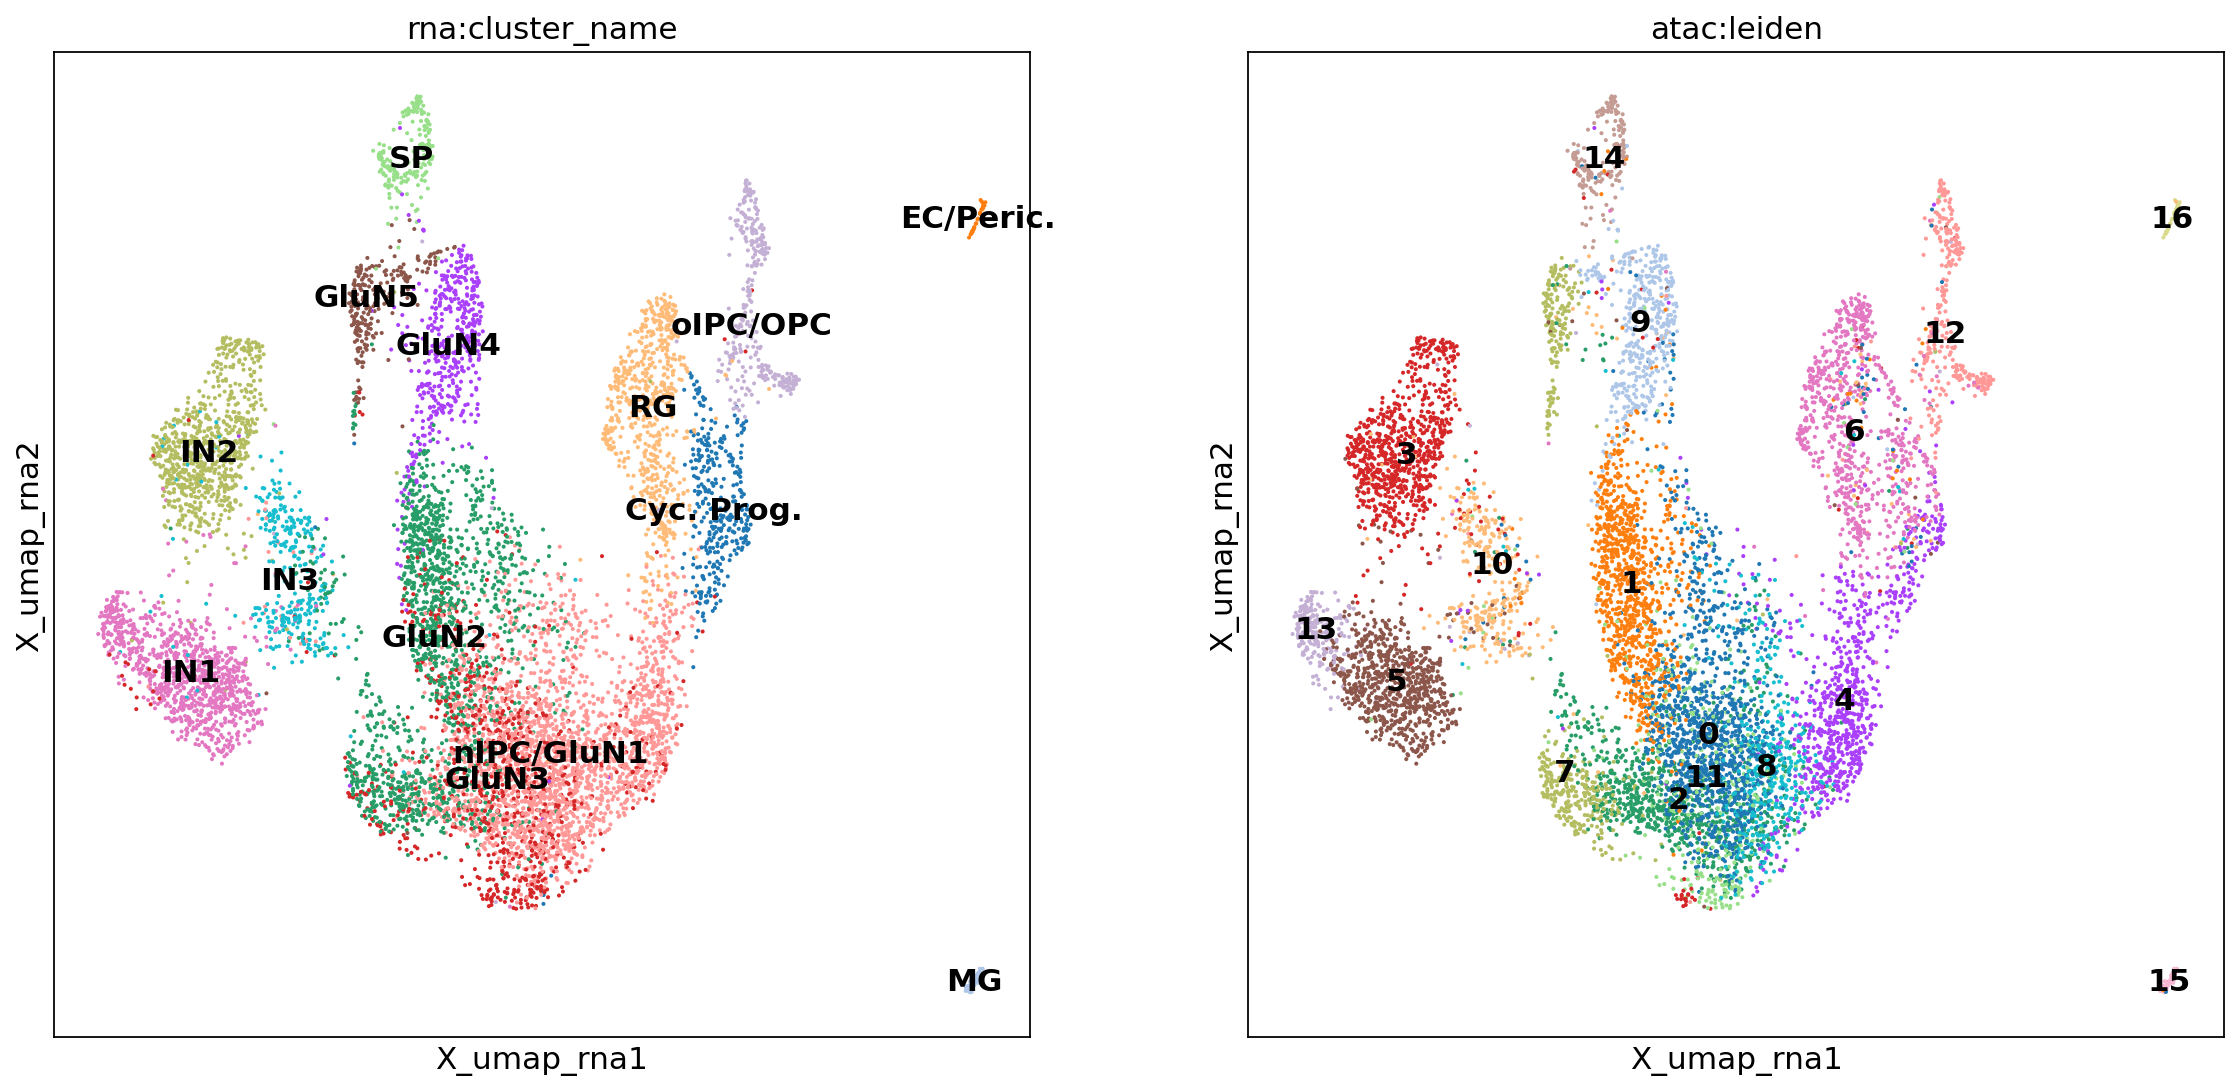

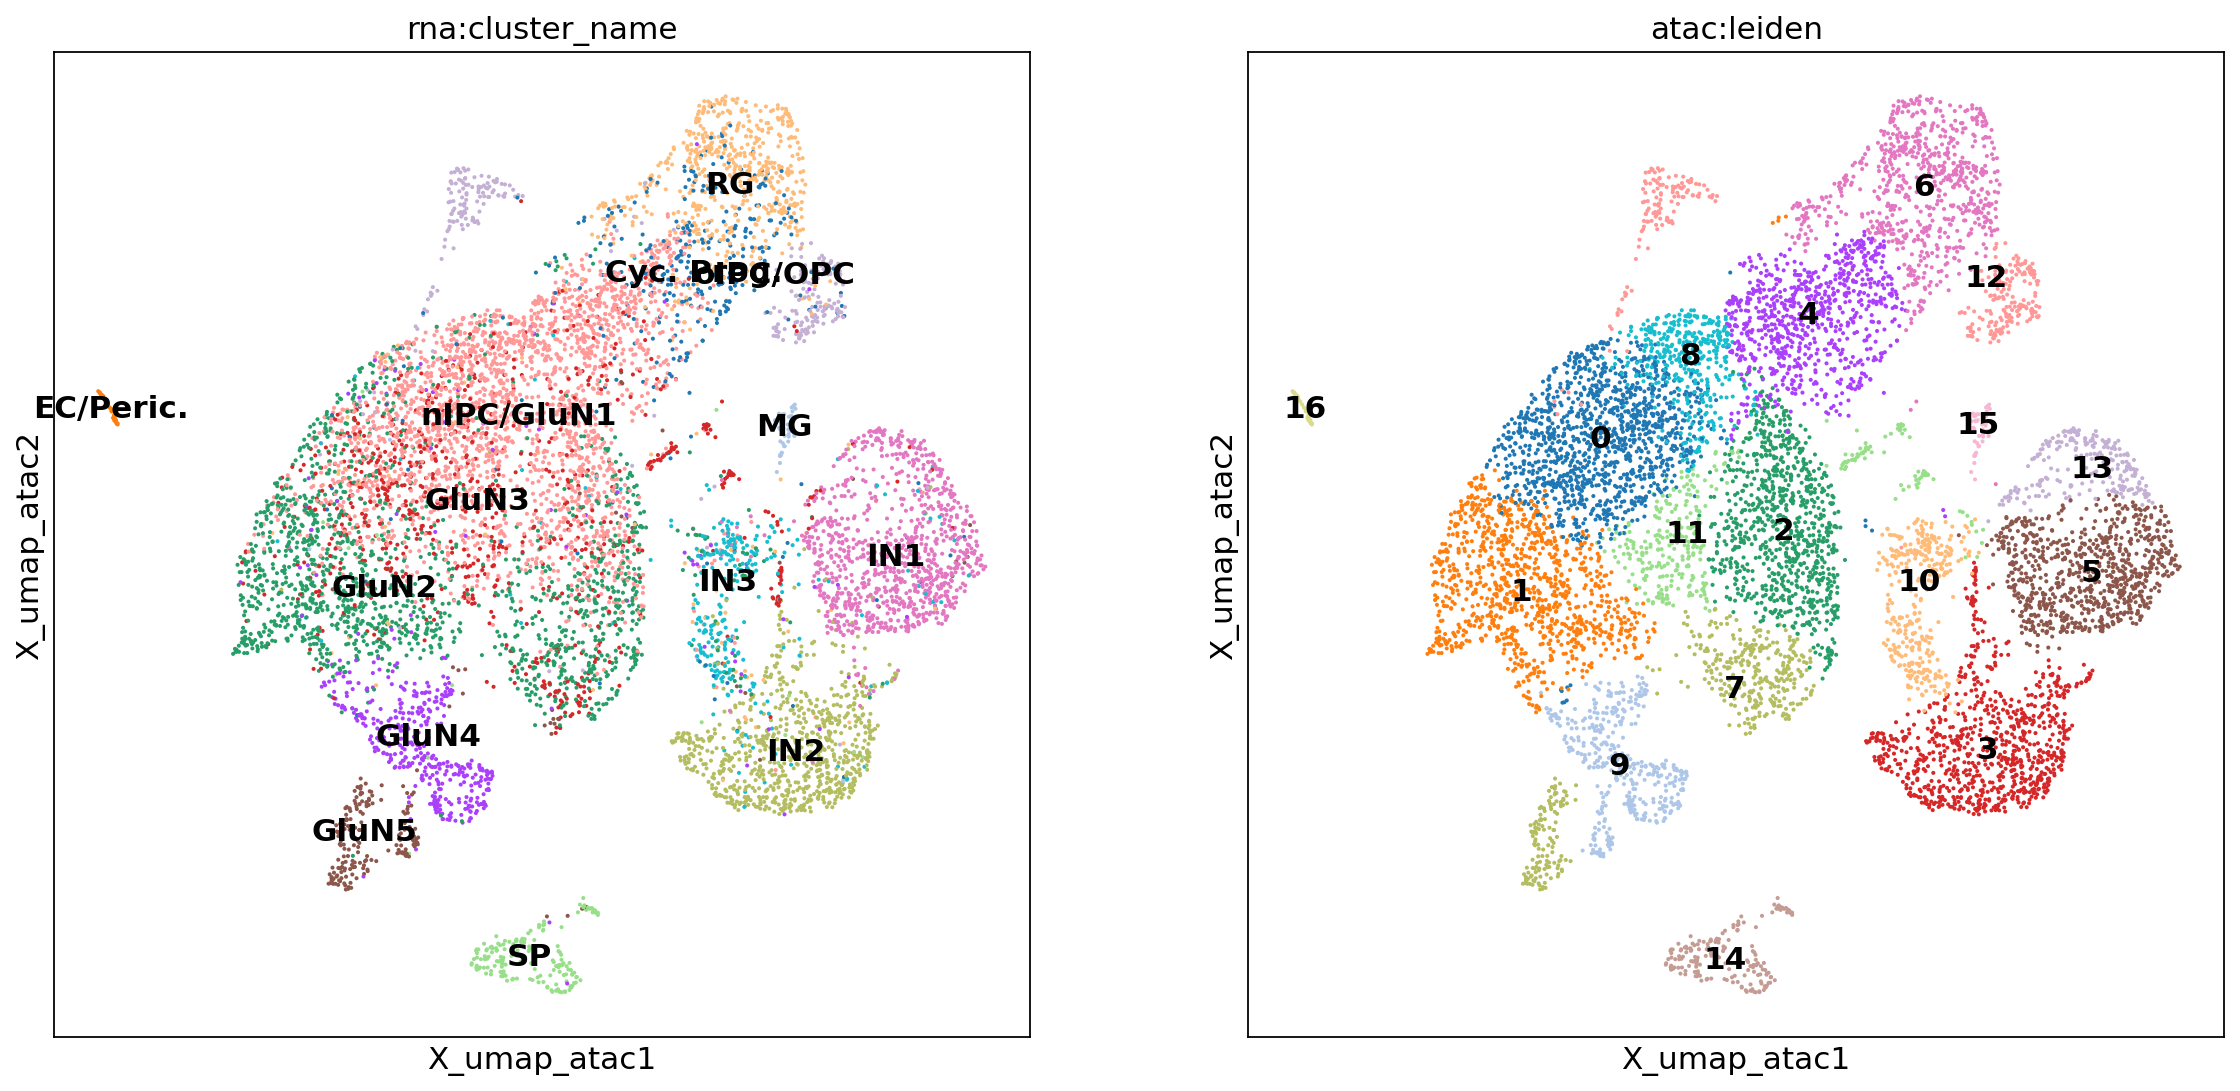

In [130]:
sc.pl.embedding(mdata, basis="X_umap_rna", color=['rna:cluster_name','atac:leiden'] , legend_loc='on data')
sc.pl.embedding(mdata, basis="X_umap_atac", color=['rna:cluster_name','atac:leiden'], legend_loc='on data')

### Exercise 2

Use the labels on the gene expression clusters to annotate the clusters in chromatin accessibility. Which RNA clusters are mixed in chromatin accessibility? The utility function `sc.metrics.confusion_matrix` might be useful here.

<AxesSubplot:xlabel='atac:leiden', ylabel='rna:cluster_name'>

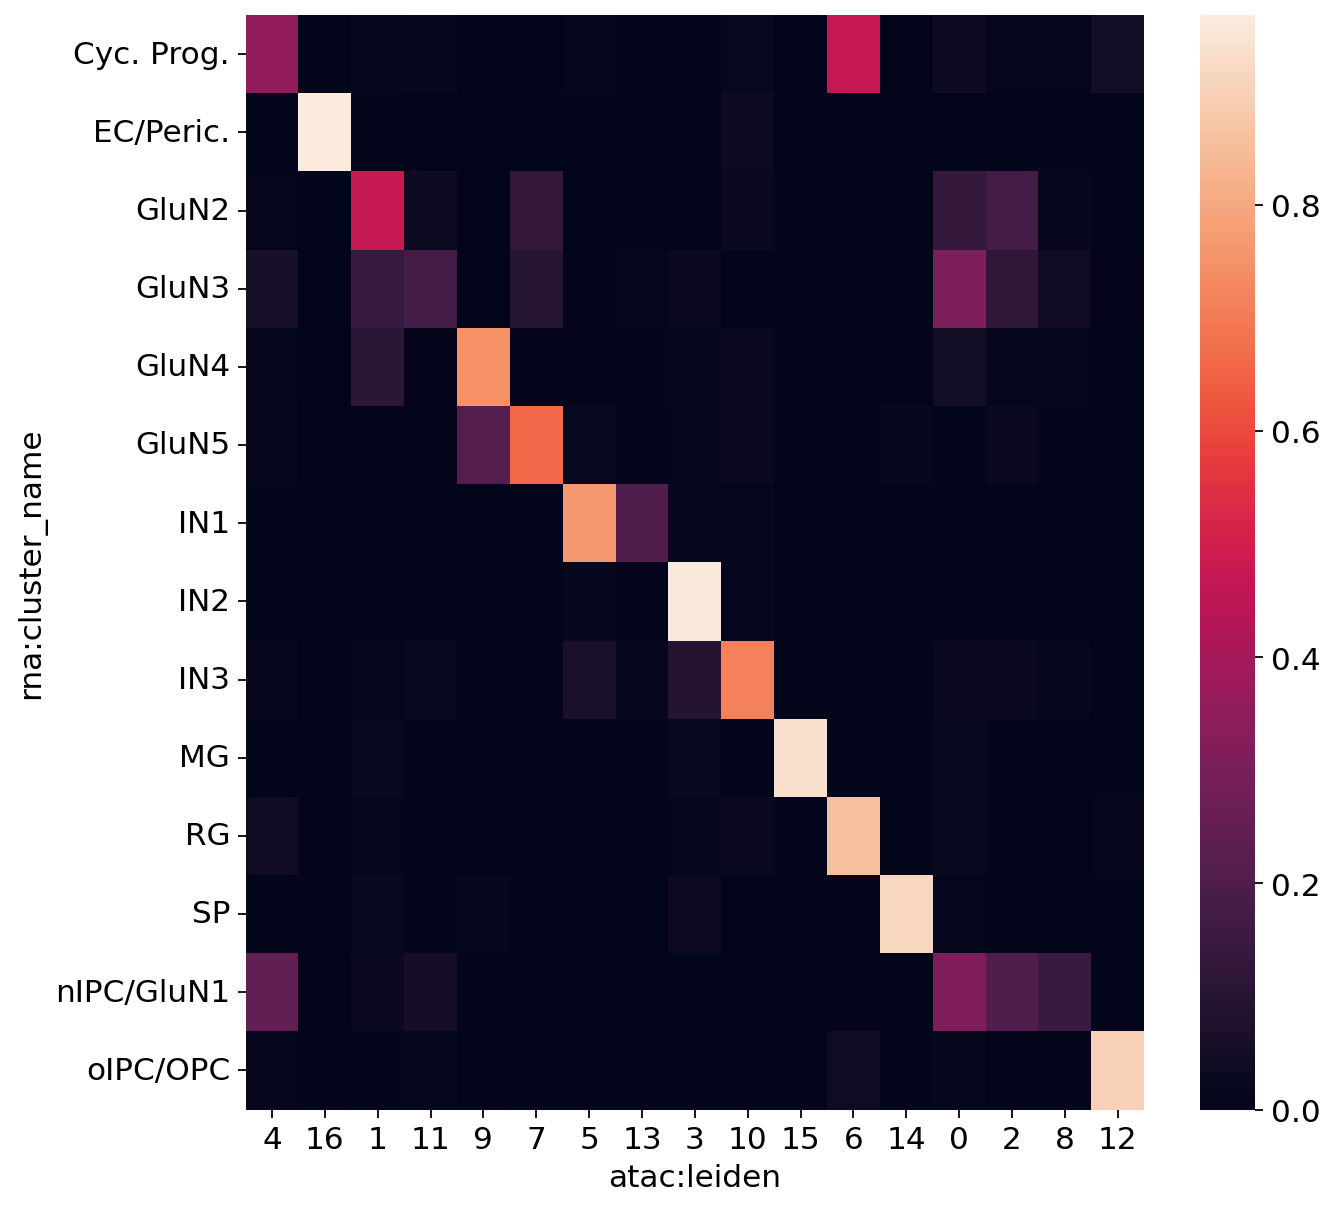

In [27]:
conf_matrix = sc.metrics.confusion_matrix('rna:cluster_name','atac:leiden', mdata.obs[['rna:cluster_name','atac:leiden']])
## reorder columns to get a diagonal
row_order = conf_matrix.idxmax(0).sort_values().index 
conf_matrix = conf_matrix[row_order].copy()
sns.heatmap(conf_matrix)

## Step 1: Co-embedding to define a pseudotime ordering of the differentiating excitatory neurons from the nIPCs

In principle, you could just generate a latent embedding and pseudotime ordering on the scRNA modality, and take that as a representative embedding of your cells. However, it might be beneficial to incorporate information from both modalities in the embedding, using what we defined as "vertical integration" strategies. We recommend trying:

- Multi-omics factors analysis: ([paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02015-1)) 
    - Train model in R ([R package](https://github.com/bioFAM/MOFA2)) ([vignette](https://raw.githack.com/bioFAM/MOFA2_tutorials/master/R_tutorials/10x_scRNA_scATAC.html))
    - Train model in python ([vignette](https://github.com/bioFAM/mofapy2/blob/master/mofapy2/notebooks/getting_started_python.ipynb)) - be aware that you can substitute the `ent.set_data_options` step with `mu.tl._set_mofa_data_from_mudata`, to use directly on MuData objects. Muon also has a MOFA wrapper in `mu.tl.mofa`.
- Seurat V4 Weighted Nearest Neighbor analysis ([paper](https://www.cell.com/cell/fulltext/S0092-8674%2821%2900583-3))
    - Run in R ([vignette](https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html)) - you can refer to the [interoperability notebook](https://github.com/NBISweden/single-cell_sib_scilifelab_2021/blob/main/project_omics/rpy2_interoperability_examples.ipynb) to create a Seurat object and run R code within this notebook 
    - Run in python with [muon wrapper](https://muon.readthedocs.io/en/latest/omics/multi.html#weighted-nearest-neighbours)

<!-- Of note, both of these are re-implemented for MuData objects in `muon` (see [here](https://muon.readthedocs.io/en/latest/omics/multi.html)).  -->
<!-- If you prefer using the native R implementations you can refer to the [python/R interoperability notebook]() to use R code within this notebook.  -->

Other interesting approaches: j-UMAP ([code](https://github.com/canzarlab/JVis-learn)), Schema ([paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02313-2)) ([code](https://schema-multimodal.readthedocs.io/en/latest/overview.html)).

It will be interesting to assess what you gain from the joint embedding, in comparison to just using the RNA. It's worth noting that while the differences might be very subtle in the case of RNA-ATAC integration, it has been shown that there is a tangible gain in clustering resolution using these vertical integration strategies on other modalities such as RNA-protein (CITE-seq data).

An additional consideration: should you subset the data to the GluN trajectory before or after co-embedding?

### Running MOFA

In [31]:
## Select highly variable peaks from TF-IDF normalized profiles (not ideal)
sc.pp.highly_variable_genes(mdata["atac"], 
                           min_mean=0, max_mean=3, min_disp=0.1,
                           n_top_genes=5000)

In [32]:
## Subset the muon object directly
mdata.mod["rna"] = mdata.mod["rna"][:,mdata.mod["rna"].var["highly_variable"]].copy()
mdata.mod["atac"] = mdata.mod["atac"][:,mdata.mod["atac"].var["highly_variable"]].copy()

# mdata.mod["atac"] = mdata["atac"][mdata["atac"].obs["in_GluN_trajectory"]].copy()
# mdata.mod["rna"] = mdata["rna"][mdata["rna"].obs["in_GluN_trajectory"]].copy()

mdata.update()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my-conda-envs/sc2022-multiomics/lib/python3.10/site-packages/mudata/_core/mudata.py:501: UserWarning: var_names is not unique, global var is present, and varmap is empty. The update() is not well-defined, verify if global var map to the correct modality-specific var.
  warnings.warn(


Training takes approximately ~ 20 mins and ~ 15GB of RAM. To avoid waiting around the results are stored in [here]

In [37]:
## Run mofapy2
from mofapy2.run.entry_point import entry_point

# initialise the entry point
ent = entry_point()

lik = ['gaussian', 'gaussian']

ent.set_data_options(scale_views=True, scale_groups=False)
mu.tl._set_mofa_data_from_mudata(
        model=ent,
        mdata=mdata,
        likelihoods=lik
)

ent.set_model_options(factors=20)
ent.set_train_options()
ent.build()
ent.run()
ent.save(f"{output_dir}/vertical.mofa_trained.h5ad")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

Loaded view='rna' group='group1' with N=8981 samples and D=5471 features...
Loaded view='atac' group='group1' with N=8981 samples and D=5000 features...


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Sp

In [131]:
import h5py
ent = h5py.File(f'{output_dir}/vertical.mofa_trained.h5ad', 'r')
ent.keys()

<KeysViewHDF5 ['data', 'expectations', 'features', 'groups', 'intercepts', 'model_options', 'samples', 'training_opts', 'training_stats', 'variance_explained', 'views']>

When we examine variance explained by the factors in each modality, we can see that factors are mostly driven by which modality

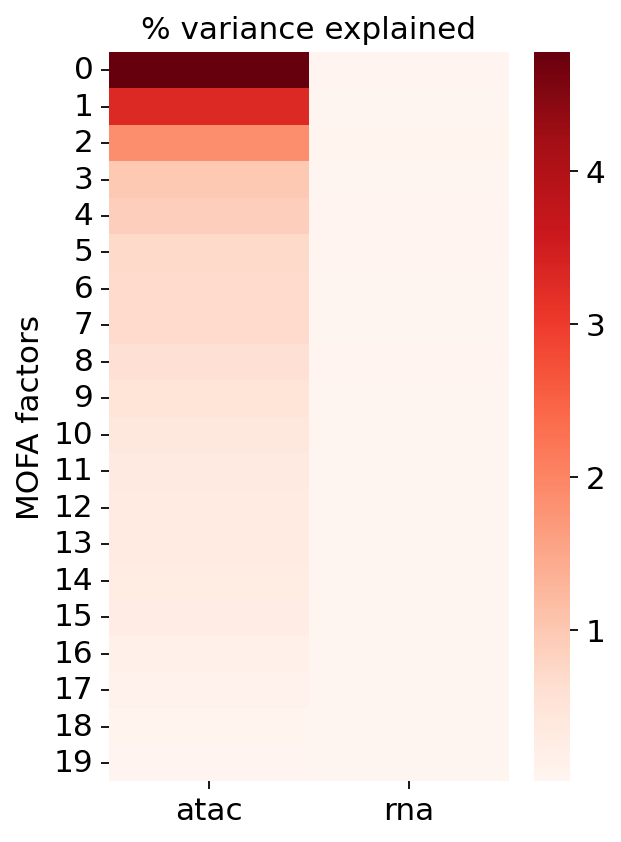

In [60]:
X_mofa = np.array(ent["expectations"]["Z"]["group1"])

plt.rcParams["figure.figsize"] = [4,6]
modalities = list(ent["data"].keys())
r2_matrix = pd.DataFrame(np.array(ent["variance_explained"]["r2_per_factor"]["group1"]).T, columns=modalities)
sns.heatmap(r2_matrix, cmap="Reds");
plt.ylabel("MOFA factors");
plt.title("% variance explained");

In [132]:
## Add MOFA embedding to the muon object
mdata.obsm['X_mofa'] = X_mofa.T

In [133]:
## Calculate KNN graph and UMAP from the MOFA latent factors
# (remember to use scanpy.pp.neighbors, not muon.pp.neighbors)
mdata.uns = {}
sc.pp.neighbors(mdata, use_rep="X_mofa", key_added="mofa")
sc.tl.umap(mdata, neighbors_key="mofa")

In [134]:
mdata.obsm["X_umap_mofa"] = mdata.obsm["X_umap"].copy() 

### WNN embedding

This uses the KNN graphs for each individual modality, stored in `mdata['rna'].obsp` and `mdata['atac'].obsp`. Therefore changing the dimensions used to calculate KNN graphs in individual modalities will affect the outcome of integration with WNN. 

In [135]:
mdata.update()
# mdata.uns = {} ## try this if mu.pp.neighbors throws error
mu.pp.neighbors(mdata)
mu.tl.umap(mdata)

In [136]:
mdata.obsm["X_umap_WNN"] = mdata.obsm["X_umap"].copy() 

By default, modality weights are added to the `mdata.obs` data frame under the `rna:mod_weight` and `prot:mod_weight`.

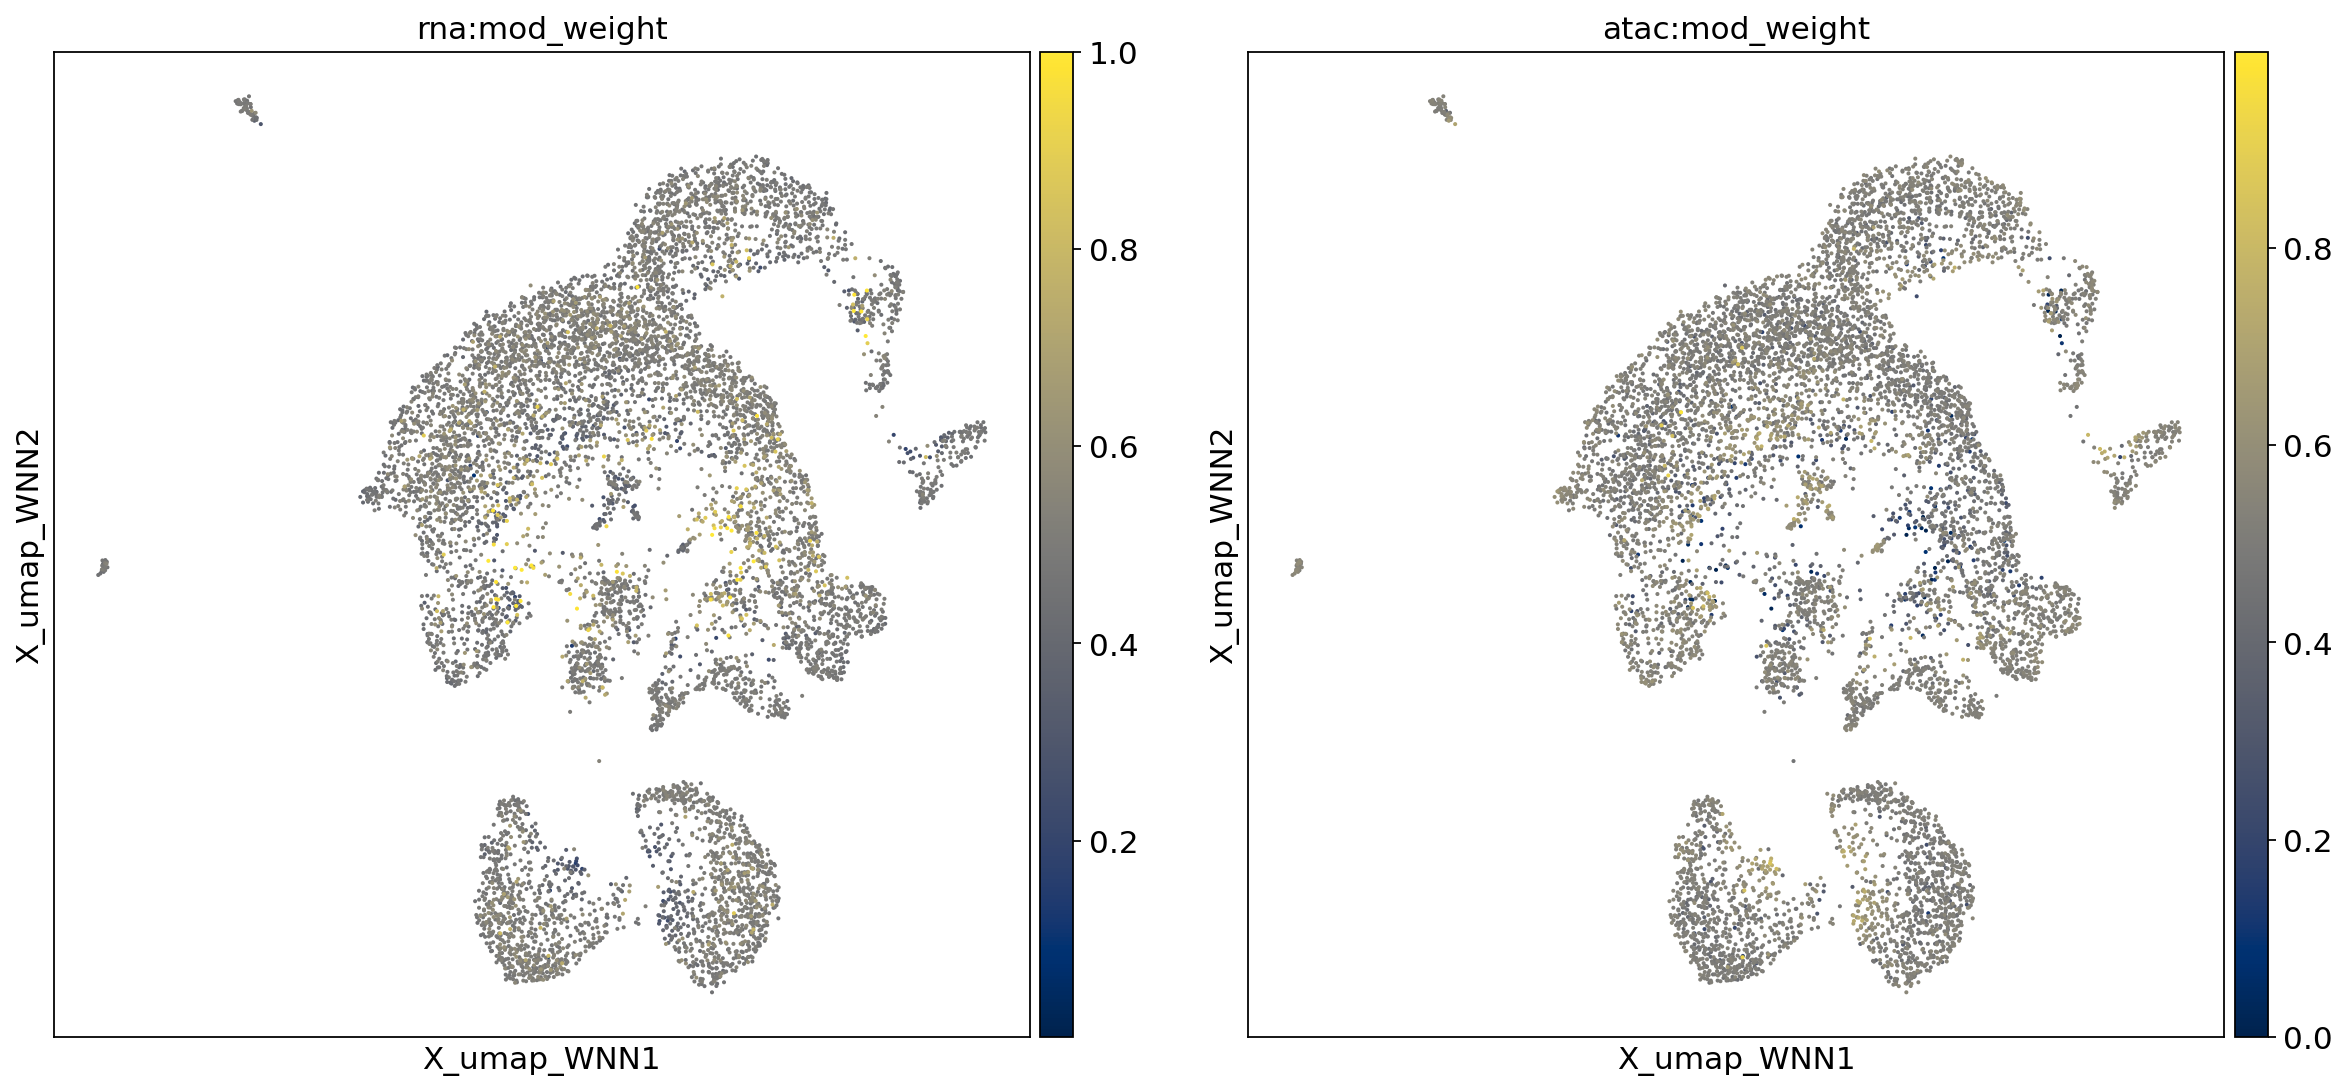

In [137]:
mu.pl.embedding(mdata, basis='X_umap_WNN', color=['rna:mod_weight', 'atac:mod_weight'], cmap='cividis')

### Question 3
Can you figure out what characterizes cells with much higher RNA modality weight than ATAC modality weight?

... storing 'rna:gene_id' as categorical
... storing 'atac:name' as categorical


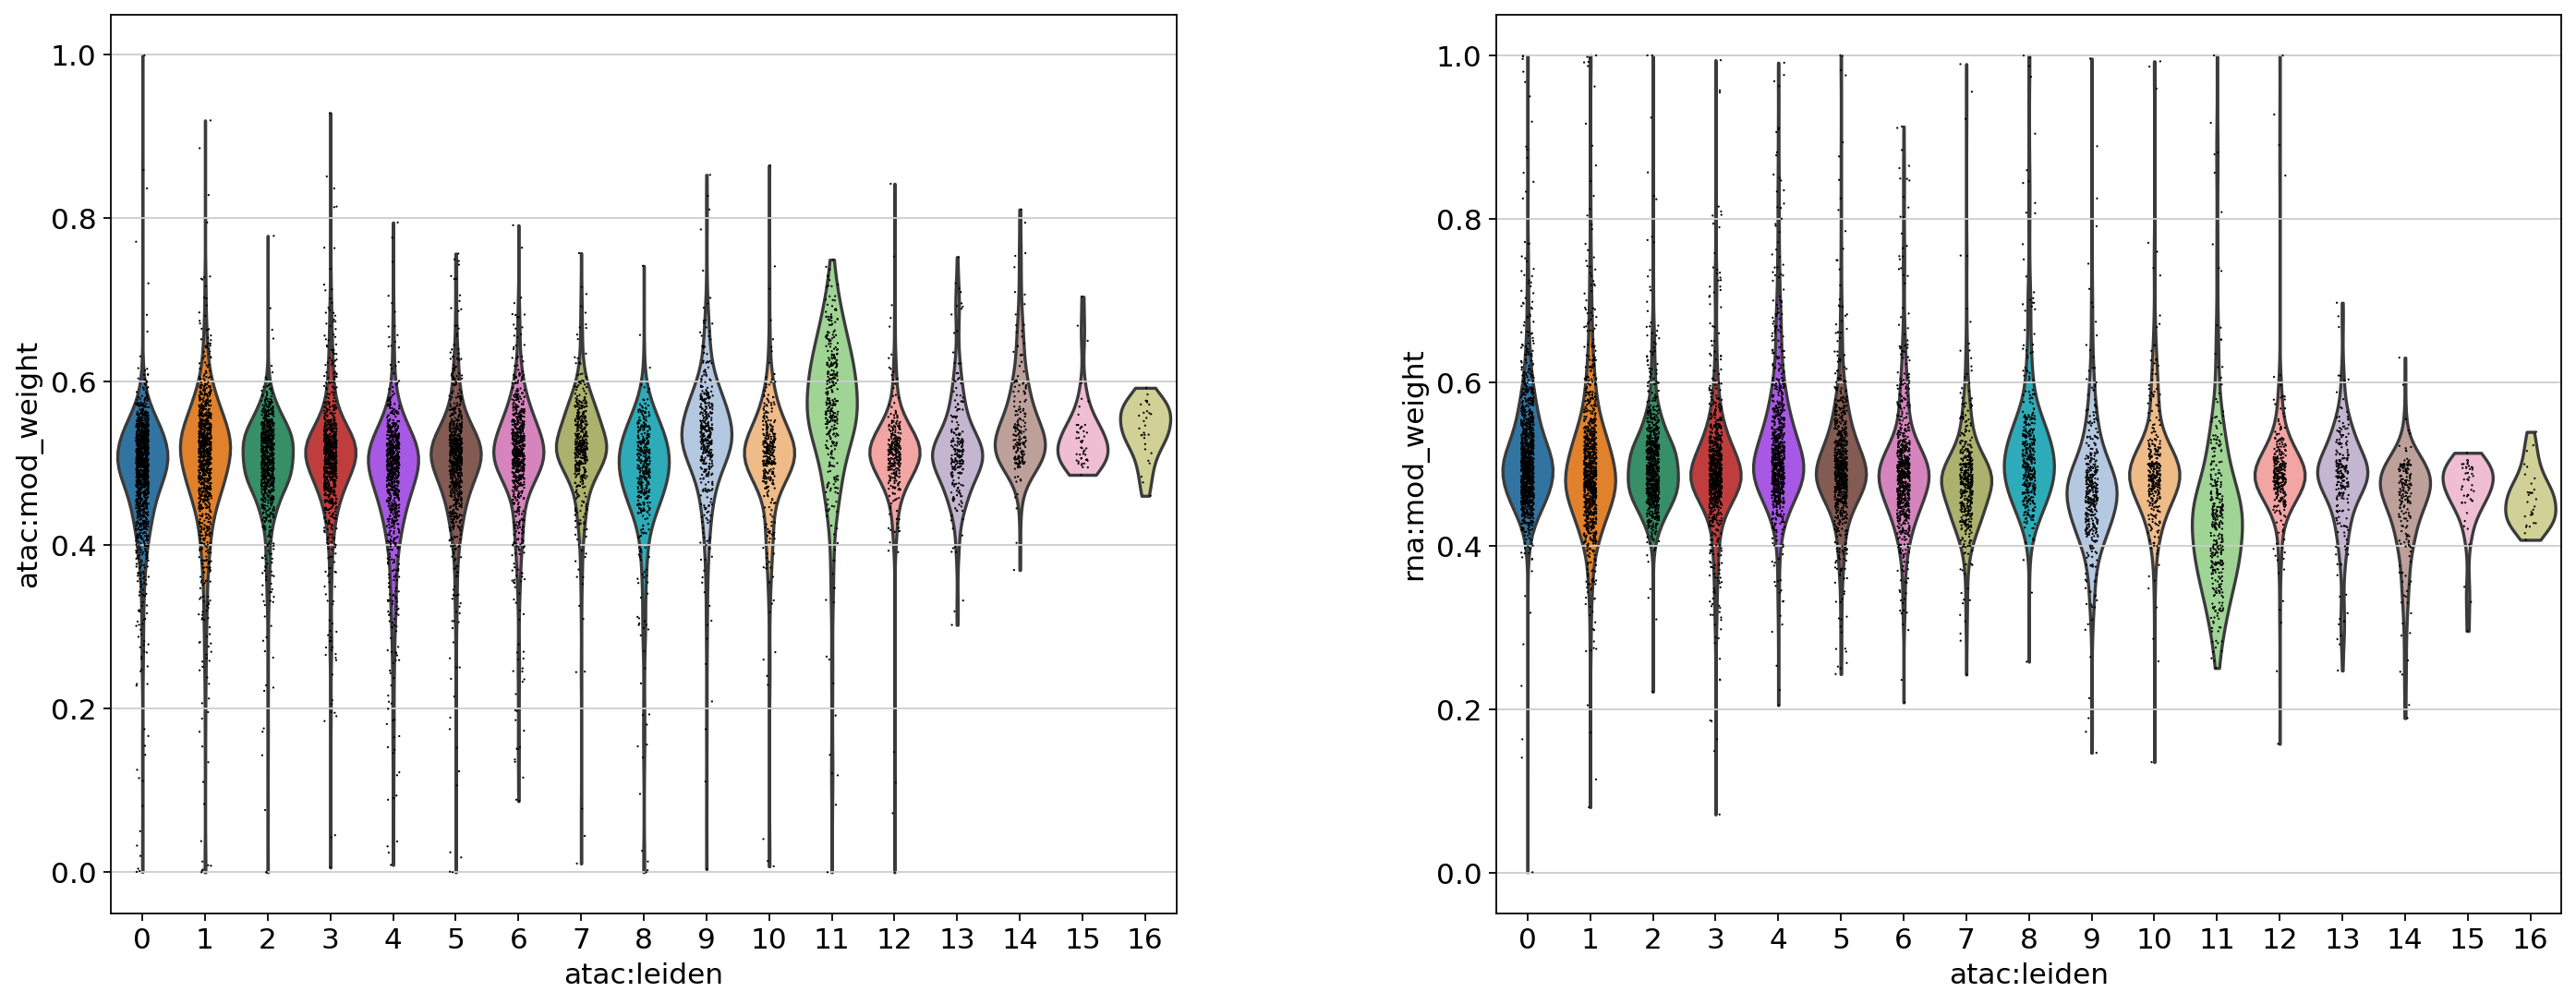

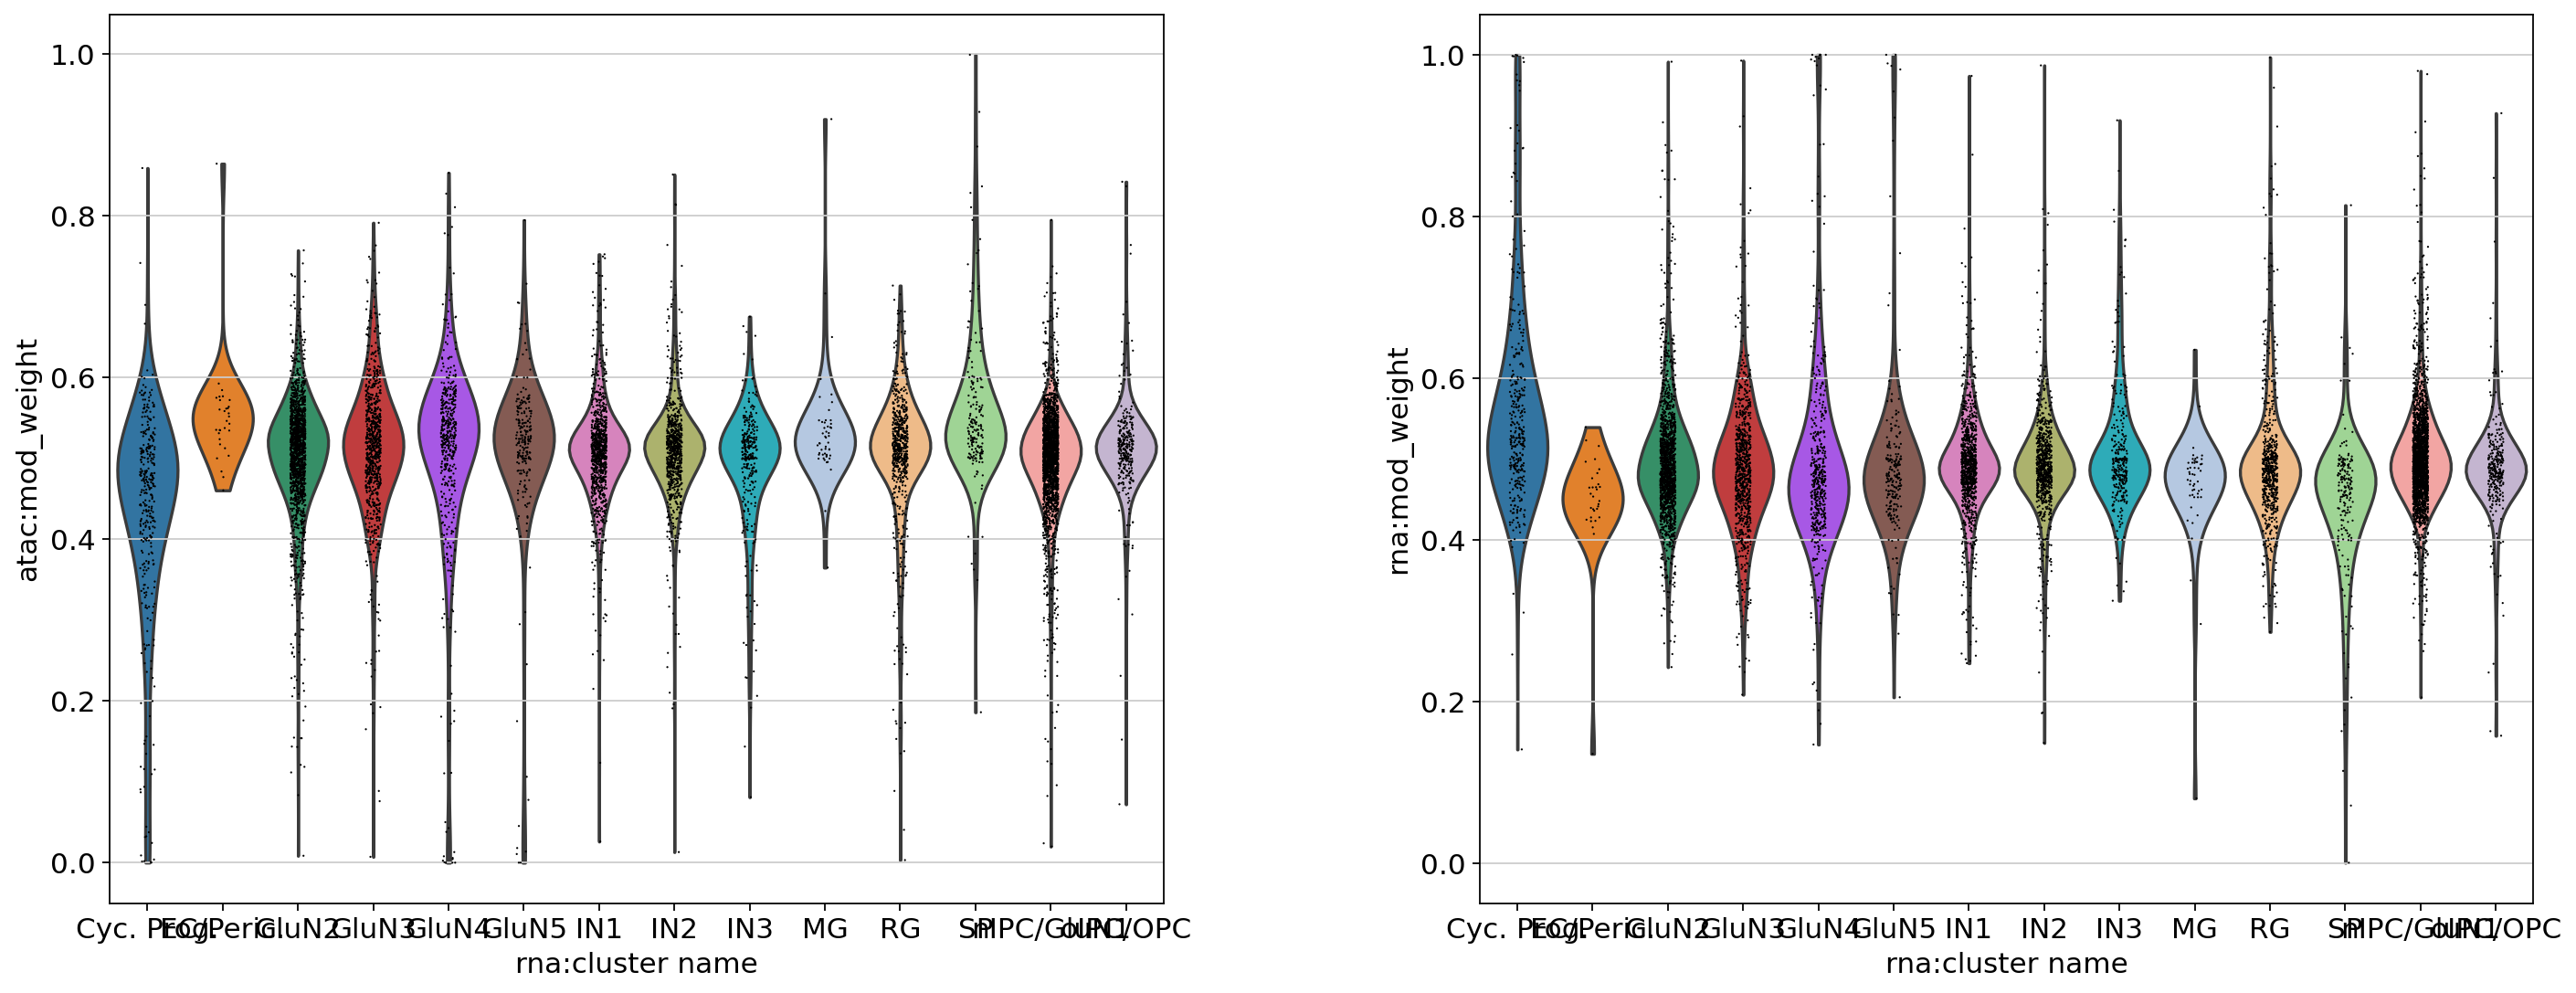

In [138]:
sc.pl.violin(mdata, groupby='atac:leiden', keys=['atac:mod_weight', 'rna:mod_weight'])
sc.pl.violin(mdata, groupby='rna:cluster_name', keys=['atac:mod_weight', 'rna:mod_weight'])

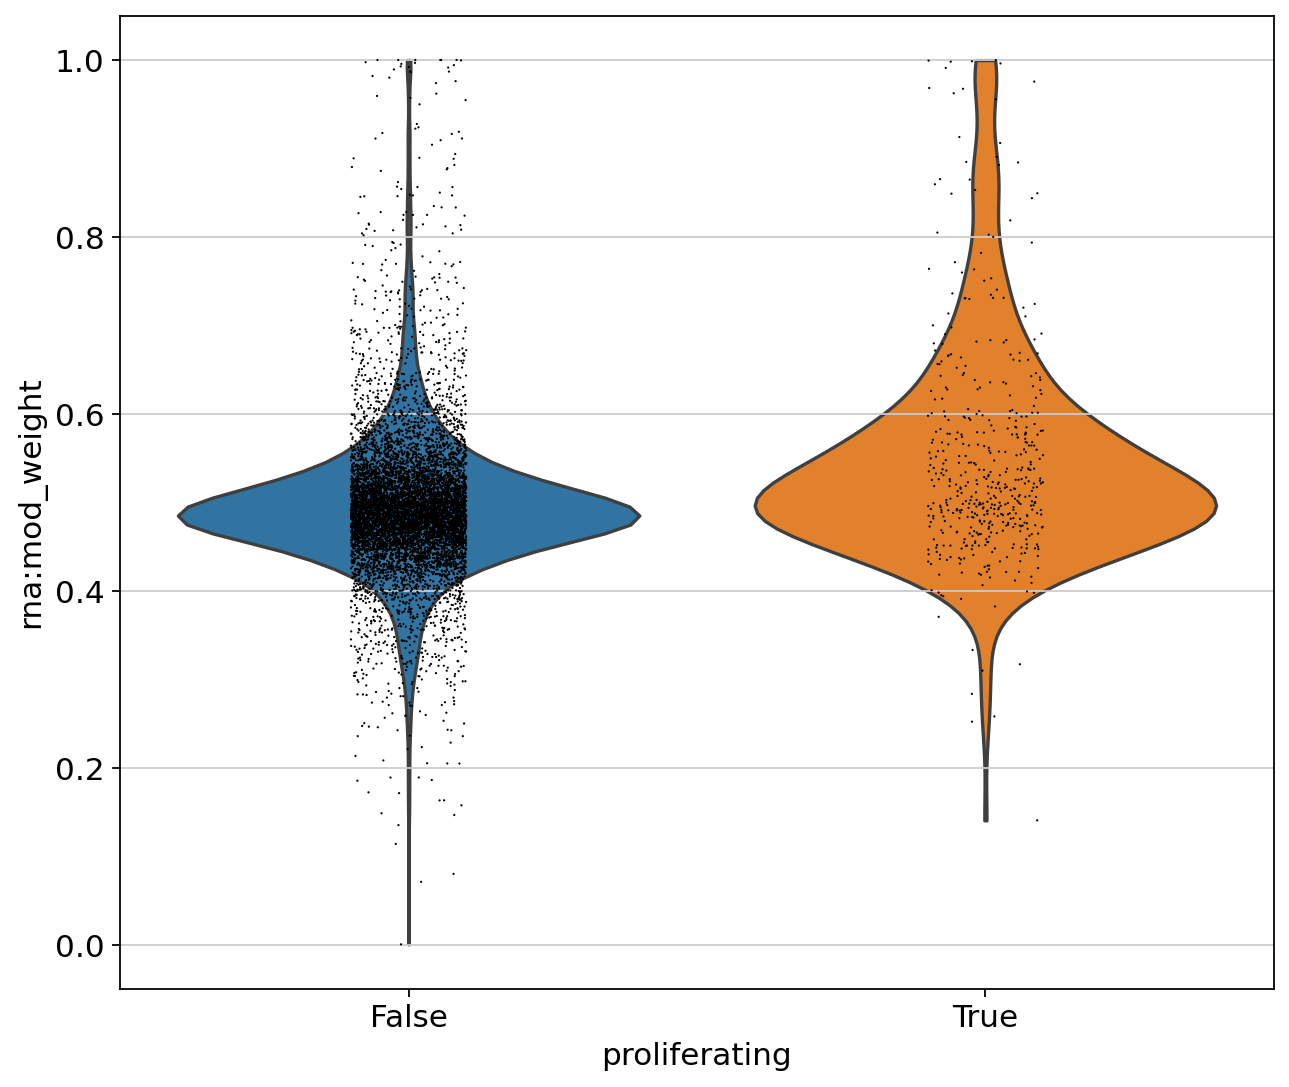

In [139]:
mdata.obs['MKI67_gex'] = mdata['rna'][:,'MKI67'].X.toarray().ravel()
mdata.obs['proliferating'] = (mdata.obs['MKI67_gex'] > 1).astype('category')
sc.pl.violin(mdata, 'rna:mod_weight', groupby='proliferating')

Save progress

In [143]:
mdata.obs['proliferating'] = mdata.obs['proliferating'].astype("bool")

In [144]:
mdata.write("{d}/vertical_clean_embeddings.h5mu".format(d=output_dir))

In [147]:
mdata = mu.read("{d}/vertical_clean_embeddings.h5mu".format(d=output_dir))

### Compare embeddings 

... storing 'rna:gene_id' as categorical
... storing 'atac:name' as categorical


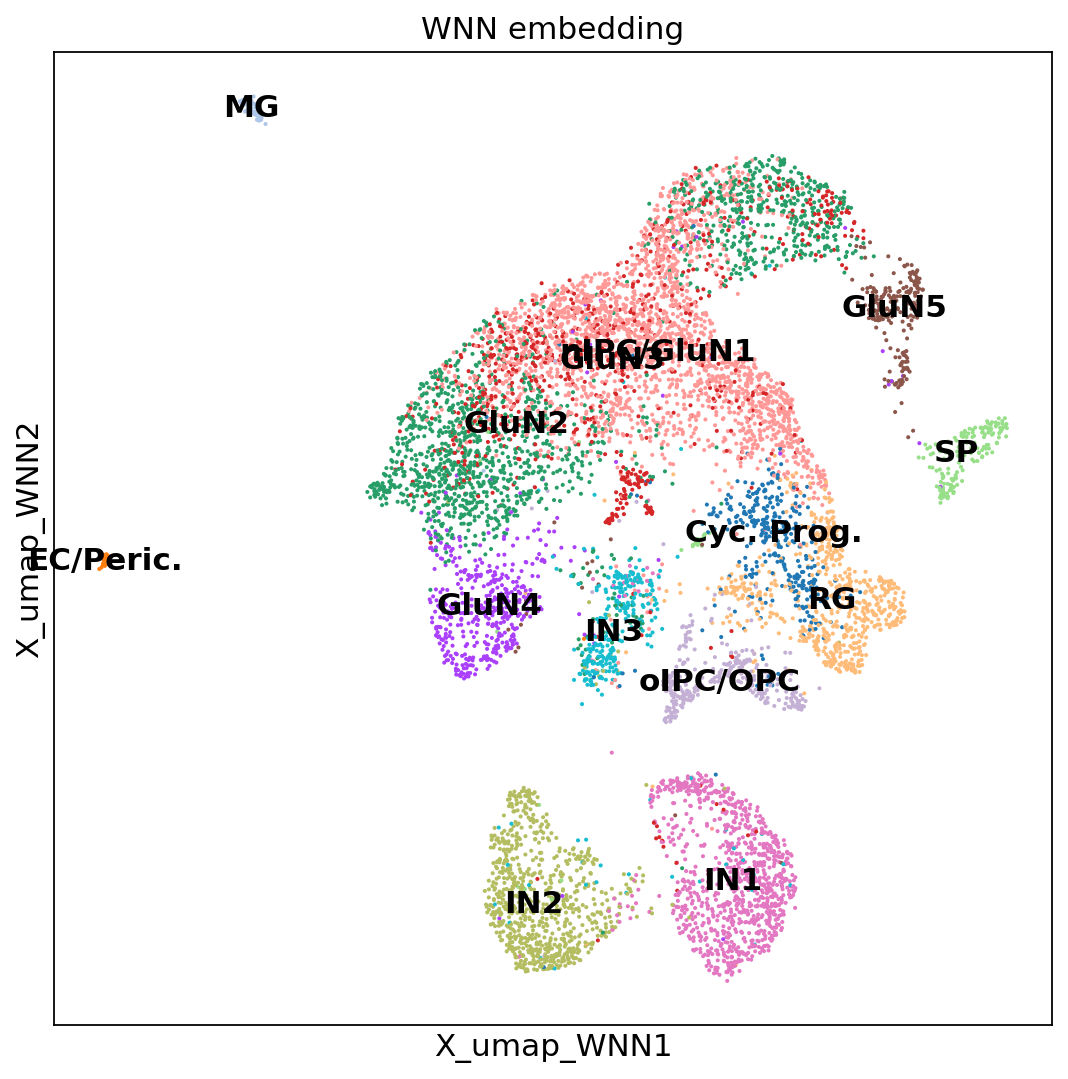

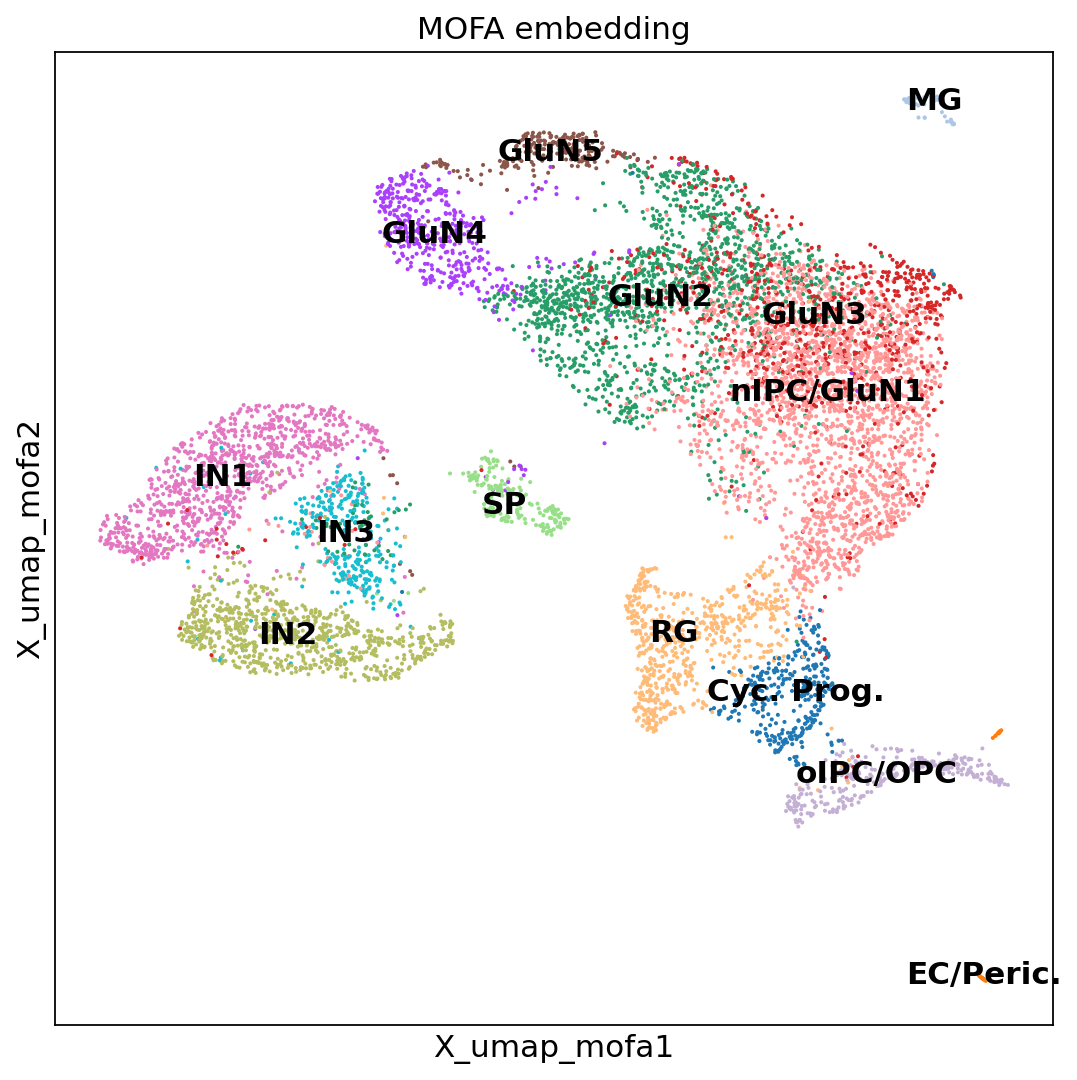

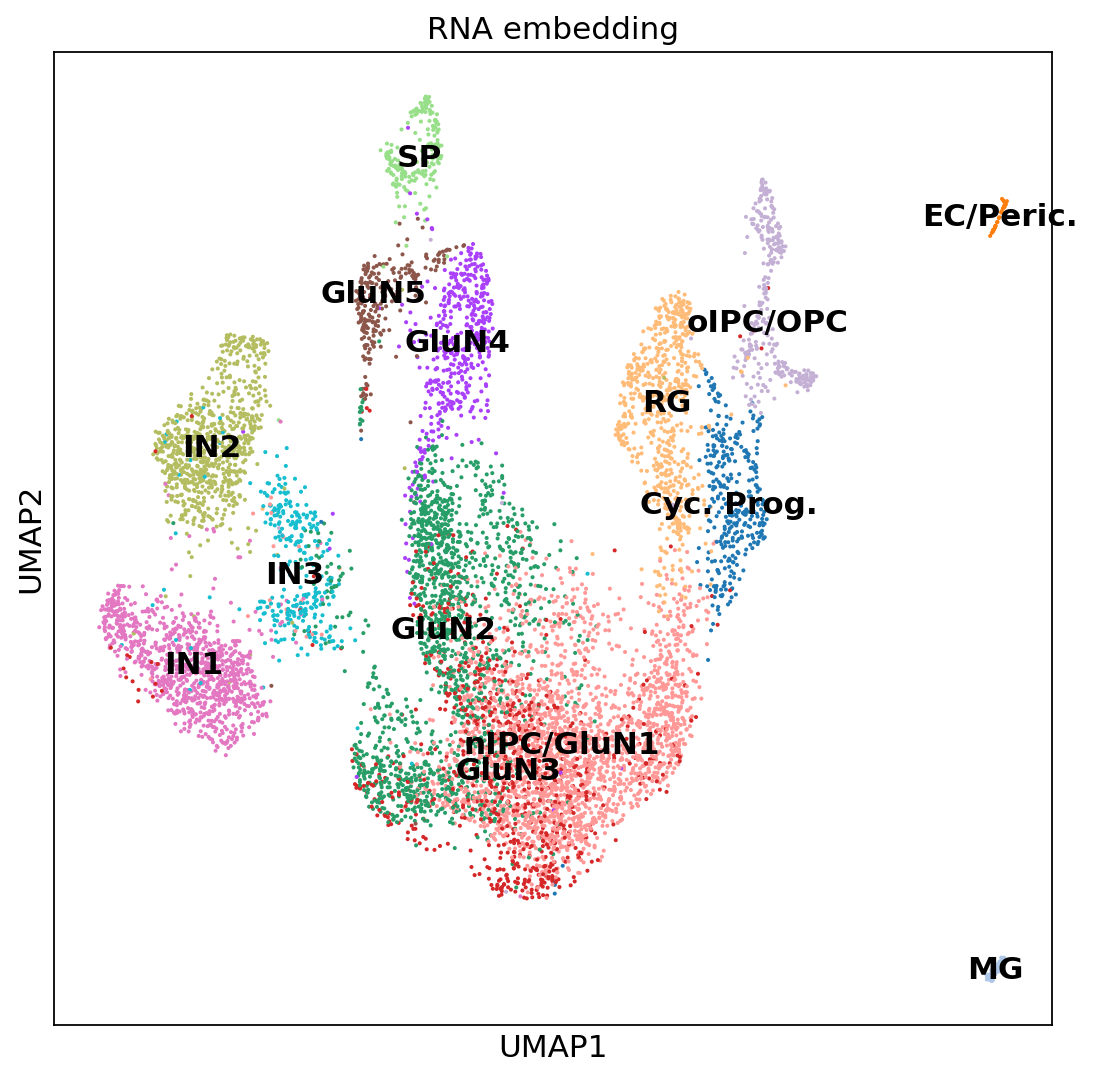

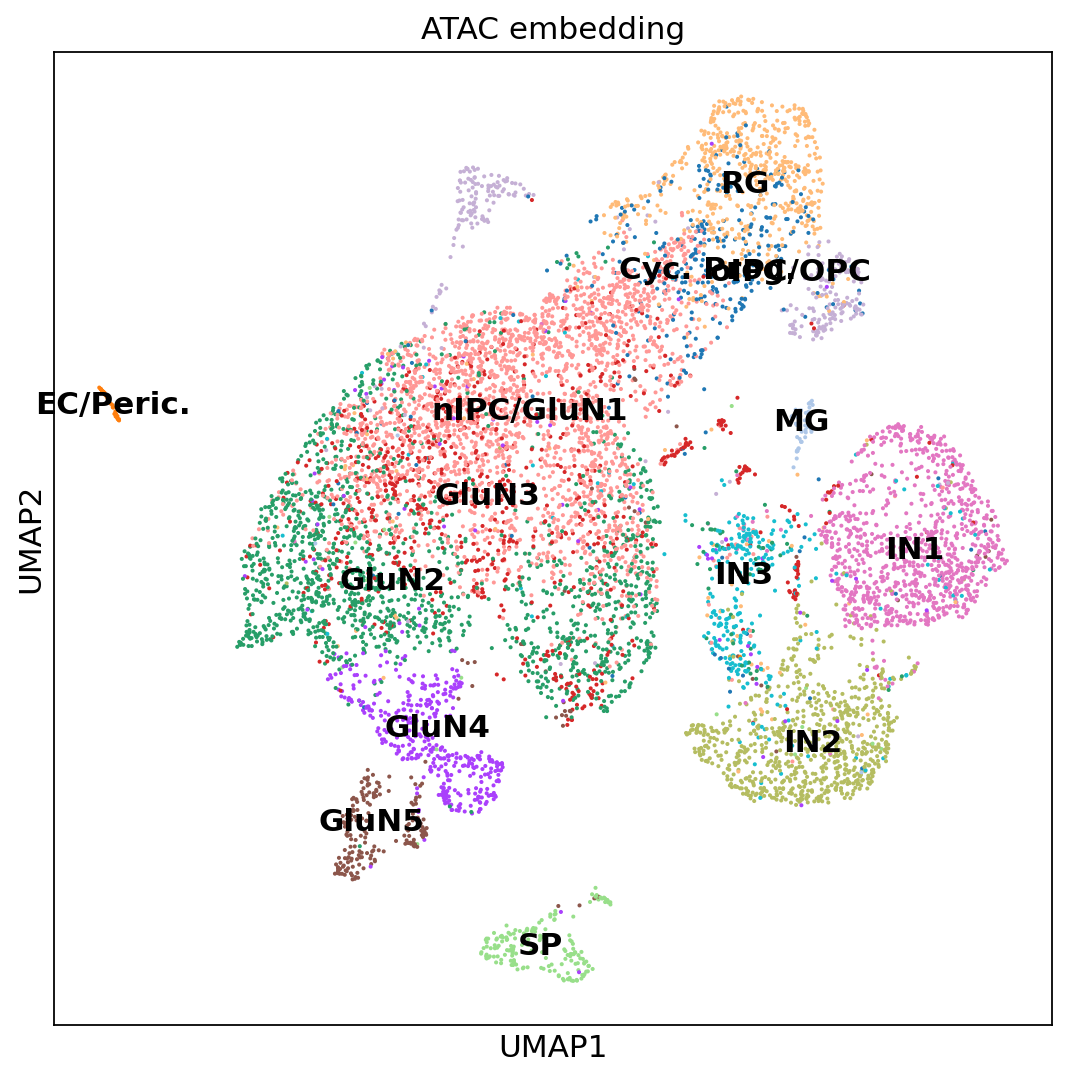

In [145]:
plt.rcParams["figure.figsize"] = [8,8]
sc.pl.embedding(mdata, basis="X_umap_WNN", color="rna:cluster_name", 
                legend_loc="on data", title="WNN embedding")
sc.pl.embedding(mdata, basis="X_umap_mofa", color="rna:cluster_name", 
                legend_loc="on data", title="MOFA embedding")
sc.pl.umap(mdata.mod['rna'], color="cluster_name", 
                legend_loc="on data", title="RNA embedding")

mdata.mod['atac'].obs['rna_cluster_name'] = mdata.obs['rna:cluster_name']
sc.pl.umap(mdata.mod['atac'], color="rna_cluster_name", 
                legend_loc="on data", title="ATAC embedding")

### Question 3
Can you quantify which multi-modal embedding (WNN or MOFA) conserves the structure of the individual modalities better? For example by comparing the agreement of clustering on the multi-modal graph with clustering on both single-omic graphs? Or you could compare the outcome of diffusion based pseudotime ordering (see example on RNA modality [here]())

A notable difference in these embeddings is in the separation of the Cycling Progenitor cells, which we don't expect to be distinct in chromatin accessibility profiles. Another difference in the SP cluster (subplate neurons), which is disconnected from GluN neurons in the chromatin accessibility embedding.

Let's compare diffusion pseudotime trajectories: we define the root cell based on RNA embedding

In [146]:
## filter to gluN trajectory 
# (note that clusters are not exactly the same between modalities,
# so pick either annotation in RNA or in ATAC)
mdata = mdata[mdata['rna'].obs['in_GluN_trajectory']].copy()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

KeyboardInterrupt



In [ ]:
sc.pp.pca(mdata.mod['rna'])
sc.pp.neighbors(mdata.mod['rna'], n_neighbors=10, n_pcs=30)
sc.tl.diffmap(mdata['rna'])

In [ ]:
sc.pl.diffmap(mdata['rna'], color='cluster_name', legend_loc="on data")

In [ ]:
## Define the putative root cell (start of differentiation trajectory)
## we take the maximum for DC1 as the root nIPC
mdata['rna'].uns['iroot'] = mdata['rna'].obsm["X_diffmap"][:,1].argmax() 
mdata.uns['iroot'] = mdata['rna'].obsm["X_diffmap"][:,1].argmax() 

sc.tl.dpt(mdata['rna'])
mdata.obs["dpt_pseudotime_rna"] = mdata['rna'].obs.dpt_pseudotime

In [ ]:
## DPT on MOFA 
sc.pp.neighbors(mdata, use_rep="X_mofa", key_added="mofa")
sc.tl.diffmap(mdata, neighbors_key='mofa')
sc.tl.dpt(mdata, neighbors_key="mofa")
mdata.obs["dpt_pseudotime_MOFA"] = mdata.obs.dpt_pseudotime

In [ ]:
## DPT on WNN
# recompute on subset
sc.pp.neighbors(mdata["rna"], use_rep="X_pca", n_neighbors=10, n_pcs=30)
sc.pp.neighbors(mdata["atac"], use_rep="X_lsi", n_neighbors=10, n_pcs=30)
mu.pp.neighbors(mdata) 

In [ ]:
sc.tl.diffmap(mdata)
sc.tl.dpt(mdata)
mdata.obs["dpt_pseudotime_WNN"] = mdata.obs.dpt_pseudotime

We can compare the pseudotime ordering from the different embeddings

In [ ]:
sc.pl.scatter(mdata, 'dpt_pseudotime_rna', 'dpt_pseudotime_WNN', color="rna:cluster_name")
sc.pl.scatter(mdata, 'dpt_pseudotime_rna', 'dpt_pseudotime_MOFA', color="rna:cluster_name")
sc.pl.scatter(mdata, 'dpt_pseudotime_WNN', 'dpt_pseudotime_MOFA', color="rna:cluster_name")

The multi-omic embeddings seem to distinguish better cluster GluN5 and GluN4 in pseudotime ordering.

In [ ]:
mdata.var_names_make_unique()

In [ ]:
sc.pl.violin(mdata, ["dpt_pseudotime_rna", "dpt_pseudotime_WNN", "dpt_pseudotime_MOFA"], groupby="rna:cluster_name")

## Quantify the agreement between gene accessibility and gene expression

- On average, are gene expression and accessibility of gene bodies and promoters related?
- Does this vary by cluster?
- Are proximal intergenic regions are more predictive of gene expression that gene accessibility? 

For this analysis, it is advisable to perform denoising of data using KNN imputation, where we substitute the profile of a cell with the average profile of the cell and its k nearest neighbors.

In [415]:
def knn_smoothing(X_features, connectivities):
    '''
    Transform cell profile to average profile of neighbors
    
    params:
    -------
    - X_features: sparse matrix of dimensions cells x features to denoise
    - connectivities: connectivity matrix for KNN graph of dimensions cells x cells
    '''
    X_imputed = (
        scipy.sparse.csr_matrix.dot(connectivities.T, X_features)
        .astype(np.float32)
    )
    if scipy.sparse.issparse(X_imputed):
        X_imputed = X_imputed.A
    X_imputed = X_imputed / X_features.sum(1).reshape(X_features.shape[0], 1)
    X_imputed = np.array(X_imputed)
    X_imputed[np.isnan(X_imputed)] = 0
    X_imputed[np.isinf(X_imputed)] = 0
    return(X_imputed)

# X_gex = mdata['rna'].X.copy()
# mdata['rna'].layers['knn_smoothed_logcounts'] = knn_smoothing(X_gex, mdata.obsp["mofa_connectivities"])

# X_gene_activity = mdata['atac'].obsm['gene_activity'].copy()
# mdata['atac'].obsm['knn_smoothed_gene_activity'] = knn_smoothing(X_gene_activity, mdata.obsp["mofa_connectivities"])

Then we need the genomic locations of genes. In this case we have saved this info in `mdata['rna'].var`, or you can access genomic ranges using pyensembl.

In [250]:
from pyensembl import EnsemblRelease
def ens_genes2df(genes):
    '''
    Convert pyemsembl genes to feature 
    dataframe readable by muon
    '''
    genes_df = pd.DataFrame()
    genes_df['Chromosome'] = ["chr" + x.contig for x in genes]
    genes_df['Start'] = [x.start for x in genes]
    genes_df['End'] = [x.end for x in genes]
    genes_df['GeneName'] = [x.gene_name for x in genes]
    genes_df['GeneID'] = [x.gene_id for x in genes]
    return(genes_df)

data = EnsemblRelease(77)
gene_names = data.genes()
genes_df = ens_genes2df(gene_names)

In [242]:
# def get_gene_gex_and_activity(mdata,g):
#     X_gene_activity = mdata['atac'].obsm['knn_smoothed_gene_activity']
#     g_ix = np.where(mdata['atac'].uns['gene_activity_var']["GeneName"] == g)[0][0]
#     mdata.obs[f'gene_accessibility'] = X_gene_activity[:,g_ix].copy()
#     mdata.obs[f'gene_expression'] = mdata['rna'][:,g].layers['knn_smoothed_logcounts'].toarray().ravel()

# get_gene_gex_and_activity(mdata, 'CD8B')
# mdata.obs[['gene_expression', 'gene_accessibility']].corr()

# sc.pl.scatter(mdata, "gene_expression", 'gene_accessibility', size=40)

To find peaks that are overlapping or proximal to genes, we can use functionality in the [pyranges]() python package, here wrapped in a helper function.

In [379]:
def _pyranges_from_strings(pos_list):
    """
    Function to create pyranges for a `pd.Series` of strings
    (borrowed from SEAcells https://github.com/dpeerlab/SEACells)
    """
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)
                      ).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)
                    ).str.split('-').str.get(1)

    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    return gr


def _pyranges_to_strings(peaks):
    """
    Function to convert pyranges to `pd.Series` of strings of format 'chr:start-end'
    (borrowed from SEAcells https://github.com/dpeerlab/SEACells)
    """
    # Chromosome and positions
    chr = peaks.Chromosome.astype(str).values
    start = peaks.Start.astype(str).values
    end = peaks.End.astype(str).values

    # Create ranges
    gr = chr + ':' + start + '-' + end

    return gr

def peaks2gene(gene_id, 
               peaks_var, 
               all_genes_df = genes_df,
               win_size = 0,
               chr_col_name = 'seqnames'               
              ):
        '''
        Find peaks within window of gene
        
        Params:
        -------
        - gene_id: ensemblID of gene of interest
        - peaks_var: var dataframe for all peaks
        - all_genes_df: dataframe of genomic ranges for all genes (extracted via pyensembl or otherwise)
        - win_size: size of window around gene to extend
        - chr_col_name: column in peak var storing chromosome information
        
        Returns: var_names of overlapping peaks
        '''
        if 'peak_string' not in peaks_var.columns:
            var['peak_string'] = var[chr_col_name].astype('str') + ':' + var['start'].astype('str') + '-' + var['end'].astype('str')            
        
        if not gene_id.startswith("ENS"):
            raise ValueError("The gene_id should be an ensemblID")
        
        ## Convert peaks to pyranges
        peaks_gr = pyranges.PyRanges(chromosomes=var[chr_col_name], starts=var['start'], ends=var['end'])
        
        ## Convert genes to pyranges
        gene_df = all_genes_df[all_genes_df['GeneID'] == gene_id]
        gene_gr = pyranges.PyRanges(chromosomes=gene_df["Chromosome"], starts=gene_df['Start'], ends=gene_df['End'])
        
        ## Extend gene range by window size
        win_gene_gr = gene_gr.extend(win_size)
        
        ## Find overlapping peaks
        gene_peaks = peaks_gr.overlap(win_gene_gr)
        if len(gene_peaks) > 0:
            gene_peak_strings = _pyranges_to_strings(gene_peaks)
            return(var.index[var['peak_string'].isin(gene_peak_strings)])
        else:
            return([])

Because testing on all the genes would be computationally intensive, we can test this analysis first on a set of known marker genes of different stages of GluN differentiation.

In [425]:
marker_genes = ['EOMES', 'PPP1R17', 'PENK', 'NEUROG1', 'NEUROG2',
    'NEUROD2', 'TBR1', 'BCL11B', 'SATB2', 'SLC17A7']

marker_genes_df = genes_df[genes_df['GeneName'].isin(marker_genes)]

i=0
connectivities = mdata.obsp["mofa_connectivities"] ## Which KNN graph to use for smoothing

## Find peaks within 10kb
gene_peaks = peaks2gene(marker_genes_df.GeneID.iloc[i], mdata['atac'].var, win_size=10000)

## Subset adata to peaks and gene of interest
sdata_atac = mdata['atac'][:,gene_peaks].copy()
sdata_rna = mdata['rna'][:,marker_genes_df.GeneName.iloc[i]].copy()

## Run KNN smoothing on accessibility profiles
X_acc = sdata_atac.X.copy()
X_acc_smooth = knn_smoothing(X_acc, connectivities)

X_gex = sdata_rna.X.copy()
X_gex_smooth = knn_smoothing(X_gex, connectivities)

In [434]:
# Compute correlations
from scipy.stats import rankdata
from sklearn.metrics import pairwise_distances

## Compute correlations to true peaks
cors = 1 - np.ravel(pairwise_distances(np.apply_along_axis(rankdata, 1, X_acc_smooth.T),
                                       rankdata(X_gex_smooth.T).reshape(
                                           1, -1),
                                       metric='correlation'))
cors = pd.Series(cors, index = sdata_atac.var_names)

In [ ]:
# Random background
df = pd.DataFrame(1.0, index=cors.index, columns=['cor', 'pval'])
df['cor'] = cors
for p in df.index:
    try:
        # Try random sampling without replacement
        rand_peaks = np.random.choice(atac_meta_ad.var_names[(atac_meta_ad.var['GC_bin'] == atac_meta_ad.var['GC_bin'][p]) &
                                                             (atac_meta_ad.var['counts_bin'] == atac_meta_ad.var['counts_bin'][
                                                                 p])], n_rand_sample, False)
    except:
        rand_peaks = np.random.choice(atac_meta_ad.var_names[(atac_meta_ad.var['GC_bin'] == atac_meta_ad.var['GC_bin'][p]) &
                                                             (atac_meta_ad.var['counts_bin'] == atac_meta_ad.var['counts_bin'][
                                                                 p])], n_rand_sample, True)

    if type(atac_exprs) is sc.AnnData:
        X = pd.DataFrame(atac_exprs[:, rand_peaks].X.todense().T)
    else:
        X = atac_exprs.loc[:, rand_peaks].T

    rand_cors = 1 - np.ravel(pairwise_distances(np.apply_along_axis(rankdata, 1, X.values),
                                                rankdata(rna_exprs[gene].T.values).reshape(
                                                    1, -1),
                                                metric='correlation'))

    m = np.mean(rand_cors)
    v = np.std(rand_cors)

    from scipy.stats import norm
    df.loc[p, 'pval'] = 1 - norm.cdf(cors[p], m, v)

---

# old

## Step 2: Selecting features for chromatin-expression associations

Now that you have a common embedding and hopefully a common pseudotime axis, we need to select the features that we will use to associate gene expression to chromatin accessibility. We could be greedy and try to test all the possible combinations of genes and peaks, but this would likely be prohibitively computationally expensive (with > 30K genes and > 400k peaks!), not to mention the multiple testing burden we would have. In addition, we know that long range interactions on the genome are possible, but they are not very common, so it doesn't make too much sense to test for associations between genes and chromatin regions that are extremely far apart e.g. on different chromosomes. 

**Feature selection for gene expression:** select a subset of interesting genes that seem to have a dynamic behaviour in the differentiation trajectory. You could select these with standard strategies for variable gene selection (in [R](https://bioconductor.org/books/release/OSCA/feature-selection.html), in [python](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html)), or you could correlate the log-normalized gene expression to the value of pseudotime, to select genes that increase or decrease in expression during differentiation. 

For better approaches to find variable genes in pseudotime, see [tradeSeq](https://bioconductor.org/packages/release/bioc/html/tradeSeq.html) or [cellrank](https://cellrank.readthedocs.io/en/stable/auto_examples/other/plot_model.html#sphx-glr-auto-examples-other-plot-model-py).

**Feature selection for chromatin accessibility:** you'll need to decide _what type of features_ and _which features_ to use at the chromatin level:

- what type of feature: you could use all the peak identified by peak calling, or aggregate counts in peaks that contain the same transcription factor binding motifs (e.g. using [ChromVAR](https://github.com/GreenleafLab/chromVAR)), aggregate counts over peaks in larger genomic windows, collapse counts from co-accessible peaks identified using [Cicero](https://cole-trapnell-lab.github.io/cicero-release/docs_m3/#installing-cicero), any other ideas...?
- which chromatin features should be tested against which genes? Especially if you pick features defined by genomic positions, it's best to subset the possible gene-region pairs to regions within a certain range of the gene. A window of 100k base pairs is often used. See below for an example implementation (in R) to associate genes to peaks in their proximity, using the functionality from [`GenomicRanges`](https://bioconductor.org/packages/release/bioc/vignettes/GenomicRanges/inst/doc/GenomicRangesIntroduction.html).


In [16]:
%%R
library(tidyr)
## Helper functions 

## String - GRanges conversion
## Borrowed from Signac functions 
## https://satijalab.org/signac/reference/GRangesToString.html
StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}

# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing genomic locations of peaks
# @param features_gr GenomicRanges object containing genomic locations of features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix matching peaks to proximal features (peaks in rows, features in columns)
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  adj_mat <- Matrix::Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
}

R[write to console]: 
Attaching package: ‘tidyr’


R[write to console]: The following object is masked from ‘package:S4Vectors’:

    expand




Remember that the peak positions are stored in `mdata.mod["atac"].var` while you can extract genomic locations of the gene bodies using the R package [`ensembldb`](https://bioconductor.org/packages/release/bioc/vignettes/ensembldb/inst/doc/ensembldb.html#4_Retrieving_sequences_for_genetranscriptexon_models)

In [ ]:
## ...
## Your feature selection / peak-gene pairing code goes here
## ...

#### Select variable genes in pseudotime

In [97]:
from scipy.stats import pearsonr
X_logcounts = mdata['rna'].X.T
keep_genes = np.where(mdata['rna'].var["highly_variable"])[0] 
X_logcounts = X_logcounts[keep_genes,:] 
mdata['rna'].var["dpt_corr_r2"] = np.nan
mdata['rna'].var["dpt_corr_r2"] = np.nan
for i in range(X_logcounts.shape[0]):
    r2,pval = pearsonr(mdata.obs.loc[mdata["rna"].obs_names,"dpt_pseudotime_MOFA"],X_logcounts[i,:].toarray().flatten())
    mdata['rna'].var.loc[mdata["rna"].var_names[keep_genes[i]],"dpt_corr_r2"] = r2
    mdata['rna'].var.loc[mdata["rna"].var_names[keep_genes[i]],"dpt_corr_pval"] = pval

## Adjust for multiple testing
from statsmodels.stats import multitest
_,adj_pvals,_,_ = multitest.multipletests(mdata['rna'].var["dpt_corr_pval"].dropna(), method="fdr_bh")

mdata['rna'].var["dpt_corr_adj_pval"] = np.nan
mdata['rna'].var.loc[~mdata['rna'].var["dpt_corr_pval"].isna(), "dpt_corr_adj_pval"] = adj_pvals

mdata['rna'].var["dpt_corr_neg_log10_pval"] = -np.log10(mdata['rna'].var["dpt_corr_adj_pval"])

In [98]:
## We define as associated to pseudotime genes with absolute correlation > 0.2
mdata['rna'].var["dpt_associated_gene"] = abs(mdata['rna'].var["dpt_corr_r2"]) > 0.2

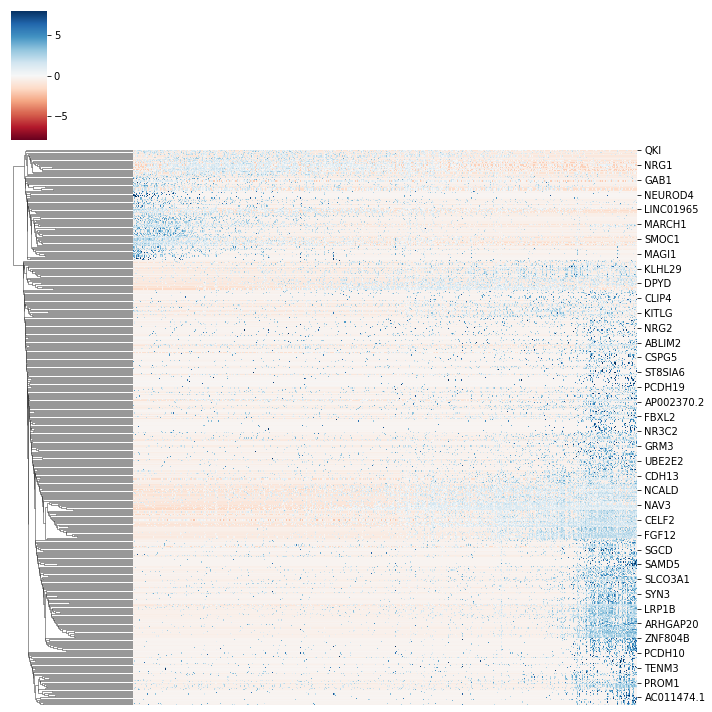

In [99]:
## Extract expression matrix with genes ordered by pseudotime
dpt_order_gex_matrix = mdata["rna"][mdata.obs.loc[mdata["rna"].obs_names,"dpt_pseudotime_MOFA"].argsort(),mdata['rna'].var["dpt_associated_gene"]].X.toarray()
dpt_order_gex_matrix = sc.pp.scale(dpt_order_gex_matrix)
dpt_order_gex_matrix = pd.DataFrame(dpt_order_gex_matrix.T)
dpt_order_gex_matrix.index = mdata['rna'].var_names[mdata['rna'].var["dpt_associated_gene"]]

import seaborn as sns
plt.rcParams["figure.figsize"] = [10,10]
sns.clustermap(dpt_order_gex_matrix, xticklabels=False, col_cluster=False, cmap="RdBu",
              vmin=-8, vmax=8)

In [103]:
## Do we find the known marker genes?
[x in mdata['rna'].var_names[mdata['rna'].var["dpt_associated_gene"]] for x in marker_genes["nIPC"] + marker_genes["GluN"]]

[True, True, True, False, False, False, False, False, True, False]

---

## Step 3: Aggregate expression/accessibility profiles from multiple cells

This step is optional, but highly recommended! In principle, we could test for correlations between gene expression and chromatin accessibility in single-cells (even the the _unmatched assays_ group can impute an accessibility profile for scRNA cells (and viceversa an expression profile for scATAC cells) taking the average profile of nearest neighbors.

However, it's worth thinking about **aggregating profiles from multiple cells**, using clustering or the KNN graph on the common embedding. This is helpful to deal with the high sparsity of the scATAC profiles, to prioritize the most robust associations and to reduce the computational burden of testing for associations. Think of how you could use a common KNN graph for this purpose: You could sample _n_ cells and create pseudobulk profiles from the K-nearest neighbors of those cells (selecting neighbourhoods where there is a sufficient number of cells from both assays in the case of unmatched data). More robust algorithms to sample neighbourhoods on the KNN graph are implemented in [miloR](https://github.com/MarioniLab/miloR) or [MetaCell](https://github.com/tanaylab/metacell). Alternatively, overclustering with the Louvain or Leiden algorithm can be used.


---

## Step 4: Associating gene expression to accessibility

To test for correlation between gene expression and chromatin accessibility, a common approach is to compute a gene-peak correlation coefficient (Spearman ⍴ or Pearson R2) by correlating normalized scATAC-seq peak peak counts with the corresponding gene’s expression across all ATAC-RNA paired cells. Then the observed coefficient for each gene-peak pair is compared to the coefficients obtained matching the gene to _n_ "background peaks" with matching total accessibility and GC content to the tested one, accounting for technical biases between cells that are caused by PCR amplification or variable Tn5 tagmentation conditions. This results in a null peak-gene correlation distribution that is independent of peak-gene proximity, that can be used for significance testing (for reference see [Ma et al. 2020](https://www.cell.com/cell/fulltext/S0092-8674(20)31253-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867420312538%3Fshowall%3Dtrue), [Kartha et al. 2021](https://www.biorxiv.org/content/10.1101/2021.07.28.453784v1.full)).

The chromVAR package implements simple functions to identify the background peaks:
```R
## In R
library(chromVAR)
library(BSgenome.Hsapiens.UCSC.hg38) ## your reference genome

atac_sce <- readRDS("./processed_data/Multiome_ATAC_ext_trajectory_SCE.RDS")
atac_chromvar_sce <- addGCBias(atac_sce, genome=BSgenome.Hsapiens.UCSC.hg38)
bg <- getBackgroundPeaks(atac_chromvar_sce, niterations = 50) ## This can take a while
```

The ArchR package also provides a [`Peak2GeneLinkage`](https://www.archrproject.com/bookdown/peak2genelinkage-with-archr.html) function to perform a similar mapping (however this only works if you follow their RNA-ATAC integration pipeline from start to finish).

So far out of the ArchR pipeline, there is no well-packaged software tool to test these associations between peaks and genes in single-cell multiomics data. Below we show an example implementation in R, adapting code from [the Buenrostro lab](https://github.com/buenrostrolab/stimATAC_analyses_code).

**Test on a few genes first!** You don't want your code to run for 10 minutes to find out it didn't work at all.


In [42]:
%%R
library(dplyr)

## Function to correlate peak expression to gene accessibility
#
# @param rna_sce a SingleCellExperiment object for RNA modality
# @param atac_sce a SingleCellExperiment object for ATAC modality
# @param pairnames a matrix of dimensions 2 * no. of pairs to test, where h 
# 
# @return updated pairnames matrix with an additional column containing 
# the spearman correlation coefficient for the pair
# 
run_p2gene_cor <- function(rna_sce, atac_sce, pairnames){
  pairnames <- as.data.frame(pairnames)
  uniq_peaks <- unique(pairnames[,1])
  uniq_genes <- unique(pairnames[,2])
  
  A = assay(atac_sce) # ATAC matrix
  R = assay(rna_sce) # RNA matrix
  
  all_peaks <- GRangesToString(rowRanges(atac_sce), sep = c("-", "-"))
  uniq_peaks_ixs <- which(all_peaks %in% uniq_peaks)
  uniq_genes_ixs <- which(rownames(R) %in% uniq_genes)
  
  M1 <- as.matrix(Matrix::t(A[uniq_peaks_ixs,,drop=FALSE])) 
  M2 <- as.matrix(Matrix::t(R[uniq_genes_ixs,,drop=FALSE])) 
  
  cormat <- cor(x = M1, y = M2, method = "spearman")
  rownames(cormat) <- all_peaks[uniq_peaks_ixs]
  colnames(cormat) <- rownames(R)[uniq_genes_ixs]
  cors <- sapply(1:nrow(pairnames), function(i) cormat[pairnames[i,1], pairnames[i,2]])
  pairnames <- cbind(pairnames, cors)
  colnames(pairnames) <- c("peak", "gene", "cor")
  return(pairnames)
}

In [340]:
%%R -i agg_atac_adata
rowRanges(agg_atac_adata) <- StringToGRanges(rownames(agg_atac_adata))
rownames(agg_atac_adata) <- peak_ids
agg_atac_adata

class: SingleCellExperiment 
dim: 444692 516 
metadata(0):
assays(1): X
rownames(444692): chr1-180451-180951 chr1-181254-181754 ...
  chr22-50783378-50783878 chr22-50807894-50808394
rowData names(0):
colnames(516): 0 1 ... 514 515
colData names(0):
reducedDimNames(0):
altExpNames(0):


In [314]:
%%R -i agg_rna_adata
agg_rna_adata

class: SingleCellExperiment 
dim: 26572 516 
metadata(0):
assays(1): X
rownames(26572): ENSG00000238009 ENSG00000241860 ... ENSG00000198695
  ENSG00000198727
rowData names(0):
colnames(516): 0 1 ... 514 515
colData names(0):
reducedDimNames(0):
altExpNames(0):


In [58]:
%%R -i pairnames
pairnames <- pairnames[pairnames[,'gene'] %in% rownames(agg_rna_adata),]
pairnames <- pairnames[pairnames[,'peak'] %in% rownames(agg_atac_adata),]
head(pairnames)

                  peak            gene
1 chr1-4637203-4637703 ENSG00000196581
2 chr1-4650315-4650815 ENSG00000196581
3 chr1-4652491-4652991 ENSG00000196581
4 chr1-4653794-4654294 ENSG00000196581
5 chr1-4654342-4654842 ENSG00000196581
6 chr1-4655017-4655517 ENSG00000196581


In [49]:
%%R
# saveRDS(agg_rna_adata, paste0(output_dir, "aggregated_RNA_SCE.RDS"))
# saveRDS(agg_atac_adata, paste0(output_dir, "aggregated_ATAC_SCE.RDS"))

NULL


In [14]:
%%R
agg_rna_adata <- readRDS(paste0(output_dir, "aggregated_RNA_SCE.RDS"))
agg_atac_adata <- readRDS(paste0(output_dir, "aggregated_ATAC_SCE.RDS"))

In [100]:
%%R 
## Compute background peaks
library(chromVAR)
library(BSgenome.Hsapiens.UCSC.hg38)

atac_sce <- readRDS("/home/jovyan/mount/gdrive/sc-multiomics-course-2021/processed_data/input/gr2_matched_vertical/Multiome_ATAC_clean_SCE.RDS")
atac_chromvar_sce <- addGCBias(atac_sce, genome=BSgenome.Hsapiens.UCSC.hg38)
atac_chromvar_sce <- atac_chromvar_sce[rowSums(assay(atac_chromvar_sce)) > 0,]
rownames(atac_chromvar_sce) <- GRangesToString(rowRanges(atac_chromvar_sce))
atac_chromvar_sce <- atac_chromvar_sce[rownames(atac_chromvar_sce) %in% rownames(agg_atac_adata),]
bg <- getBackgroundPeaks(atac_chromvar_sce, niterations = 50)
rownames(bg) <- GRangesToString(rowRanges(atac_chromvar_sce))
# bg <- bg[rownames(bg) %in% rownames(agg_atac_adata),]

In [59]:
%%R
## Compute correlation of true peak-gene pairs
cor_observed <- run_p2gene_cor(agg_rna_adata, agg_atac_adata, pairnames)
colnames(cor_observed)[3] <- "cor_observed"

In [101]:
%%R
## Find null correlation to background
n_iter = 50 ## how many background peaks to use
uniq_peaks <- rownames(bg)
for (i in 1:n_iter){
  pairnames_bg <- pairnames[,1:2] # Initialize gene-peak pairing to observed
  pairnames_bg[,1] <- uniq_peaks[bg[pairnames[,1],i]] # replace with bg peaks for iteration

  cor_bg_i <- run_p2gene_cor(agg_rna_adata, agg_atac_adata, pairnames_bg)
  cor_observed <- cbind(cor_observed, cor_bg_i[,"cor"] )
  colnames(cor_observed)[ncol(cor_observed)] <- paste0("cor_bg_", i)
  }

## Test for significance 
signif_alpha = 0.01 ## Significance threshold for p-values
permCols <- 4:(ncol(bg)+3)
cor_observed_filt <- cor_observed[cor_observed[,"cor_observed"] > 0,]   # Filter to positive correlations
  

In [102]:
%%R
# Remove multi-mapping peaks (force 1-1 mapping)
cor_observed_filt <- data.frame(cor_observed_filt) %>% group_by(peak) %>% filter(cor_observed==max(cor_observed))

# Z test pval
cor_observed_filt$rBgSD <- matrixStats::rowSds(as.matrix(cor_observed_filt[,permCols]))
cor_observed_filt$rBgMean <- rowMeans(cor_observed_filt[,permCols])
cor_observed_filt$pvalZ <- 1-stats::pnorm(q = cor_observed_filt$cor_observed, mean = cor_observed_filt$rBgMean,sd = cor_observed_filt$rBgSD)

## Filter to significant results
signif_cor_observed <- cor_observed_filt[cor_observed_filt$pvalZ < signif_alpha, c("peak","gene","cor_observed","pvalZ")]

In [103]:
%%R
write.csv(signif_cor_observed, paste0(output_dir, "signif_pairs_matched.csv"))

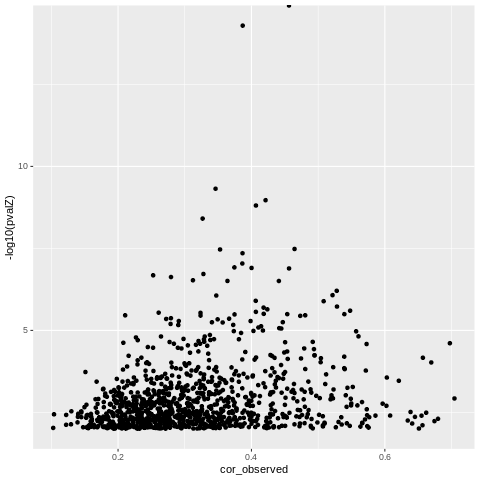

In [113]:
%%R
library(ggplot2)
ggplot(signif_cor_observed, aes(cor_observed, -log10(pvalZ))) +
geom_point()

How can you assess that your predicted associations make sense? Some ideas:
- Use positive control: e.g. we expect that peaks in the proximity of Transcription Start Sites should be more frequently linked to gene expression.
- Can you define a set of "negative control pairs" where you _don't_ expect to see association?
- Are peaks associated to genes enriched in Transcription Factor motifs? Have a look at [muon helper functions](https://muon.readthedocs.io/en/latest/api/generated/muon.atac.tl.scan_sequences.html?highlight=motif) and [motifmatchr](http://bioconductor.org/packages/release/bioc/html/motifmatchr.html).

In [114]:
%%R -o signif_cor_observed
head(signif_cor_observed)

                    peak            gene cor_observed       pvalZ
1                   <NA>            <NA>           NA          NA
2                   <NA>            <NA>           NA          NA
3                   <NA>            <NA>           NA          NA
4 chr1-11051717-11052217 ENSG00000116649    0.2468047 0.001814225
5 chr1-11060551-11061051 ENSG00000116649    0.5429873 0.006828929
6 chr1-11061653-11062153 ENSG00000116649    0.2111255 0.004322403


In [117]:
signif_cor_observed = signif_cor_observed.dropna()

### Visualize pairs on embeddings

In [196]:
# [mdata["rna"].var_names[mdata["rna"].var["gene_id"] == x for x in signif_cor_observed.gene]
mdata["rna"].var["gene_id_clean"] = [x[0] for x in mdata["rna"].var["gene_id"].str.split('.')]
signif_cor_observed['gene_name'] = [mdata["rna"].var_names[mdata["rna"].var["gene_id_clean"] == x][0] for x in signif_cor_observed.gene]

In [204]:
mdata['atac'].var
mdata['atac'].var['peak_id'] = mdata['atac'].var.seqnames.astype('str') + "-" + mdata['atac'].var.start.astype('str') + "-" + mdata['atac'].var.end.astype('str')    

mdata['atac'].var_names = mdata['atac'].var["peak_id"]

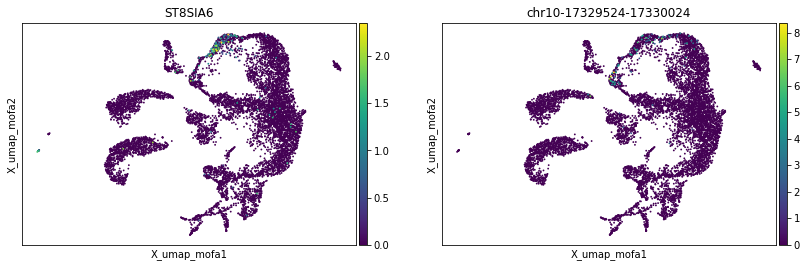

None


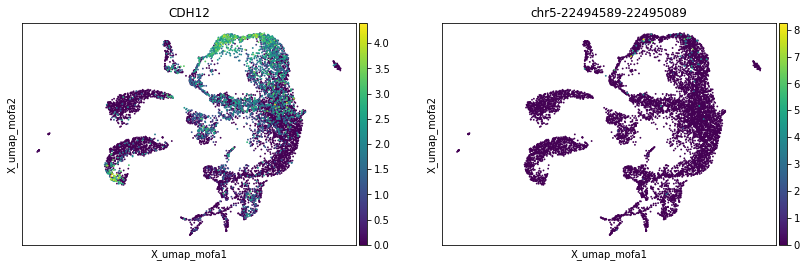

None


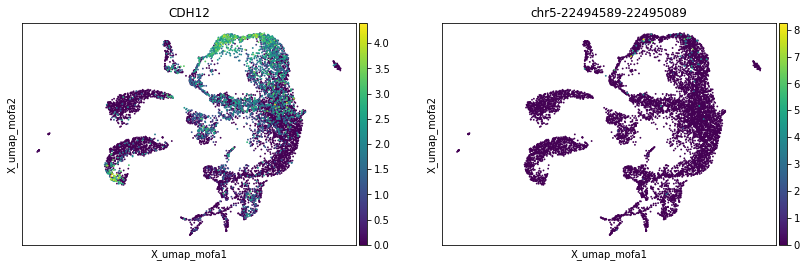

None


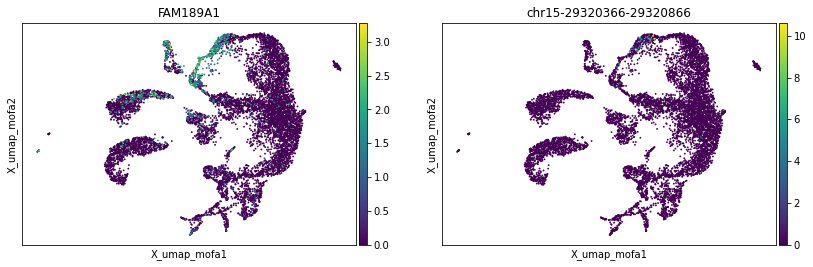

None


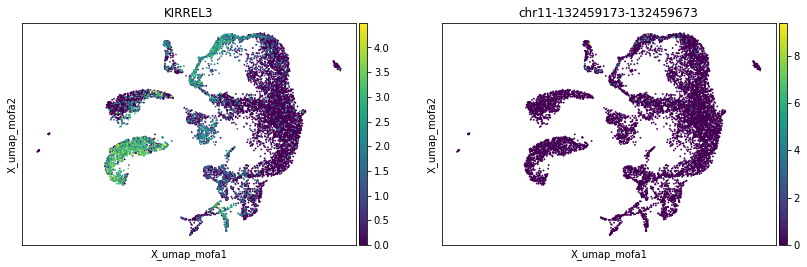

None


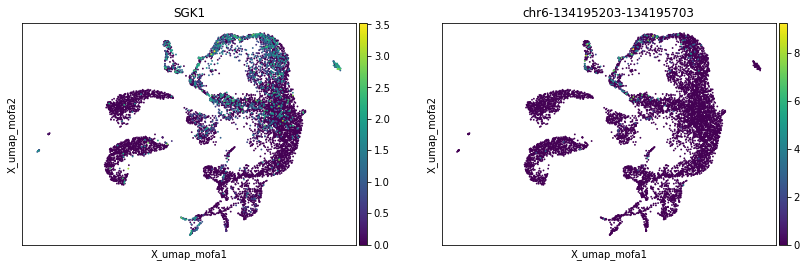

None


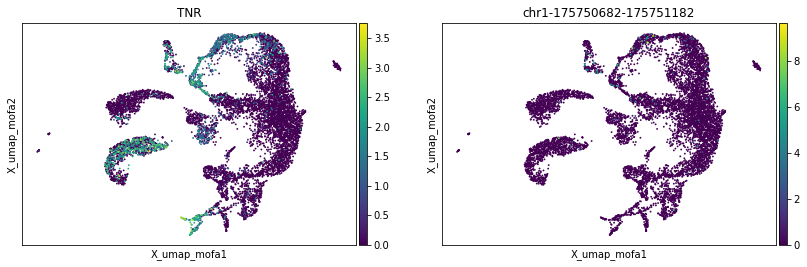

None


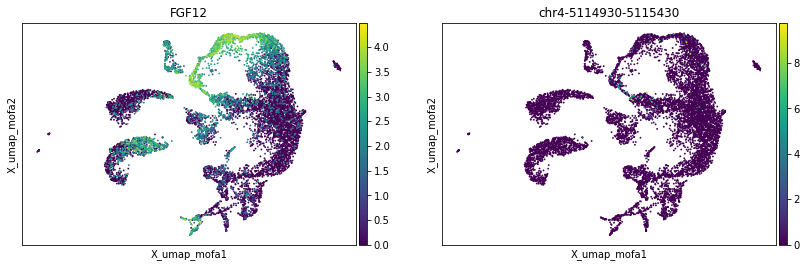

None


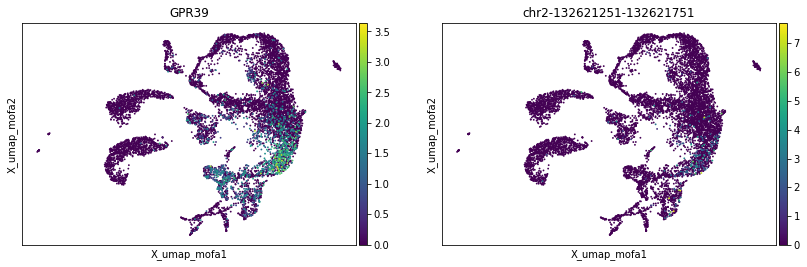

None


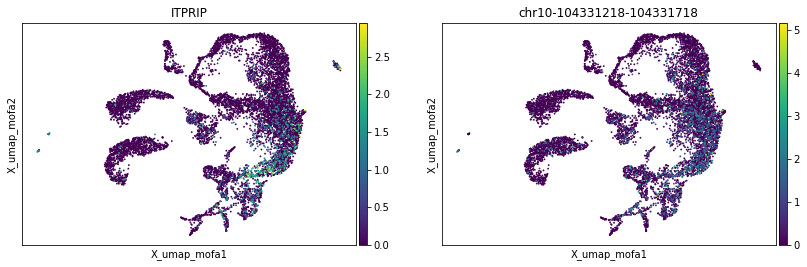

None


In [219]:
def plot_p2g_pair(mdata, g, p):
    mdata.obs['g_expression'] = mdata['rna'][:,g].X.toarray().ravel()
    mdata.obs['p_accessibility'] = mdata['atac'][:,p].X.toarray().ravel()
    sc.pl.embedding(mdata, "X_umap_mofa", color=['g_expression', 'p_accessibility'], title=(g,p))

smp_ixs = np.random.choice(signif_cor_observed[signif_cor_observed.cor_observed > 0.4].index, 10) 
for i in smp_ixs:
    print(plot_p2g_pair(mdata, signif_cor_observed['gene_name'][i], signif_cor_observed['peak'][i]))


### Distance to TSS

In [159]:
%%R -i signif_cor_observed
transcript_coords <- ensembldb::transcripts(EnsDb.Hsapiens.v86, filter = ~ gene_biotype == "protein_coding")
seqlevelsStyle(transcript_coords) <- 'UCSC'
transcript_coords <- keepStandardChromosomes(transcript_coords, pruning.mode = 'coarse')
tss_coords <- resize(unlist(range(split(transcript_coords, ~ tx_id))), width=1)

signif_peaks_gr <- StringToGRanges(signif_cor_observed[,'peak'], sep=c("-",'-'))
tss_distance <- distanceToNearest(signif_peaks_gr, tss_coords)
signif_cor_observed$tss_distance_signif <- tss_distance@elementMetadata$distance

In [160]:
%%R -o signif_cor_observed
nonsignif_peaks_gr <- StringToGRanges(sample(pairnames[,'peak'], length(signif_peaks_gr)), sep=c("-",'-'))
tss_distance <- distanceToNearest(nonsignif_peaks_gr, tss_coords)
signif_cor_observed$tss_distance_rand <- tss_distance@elementMetadata$distance

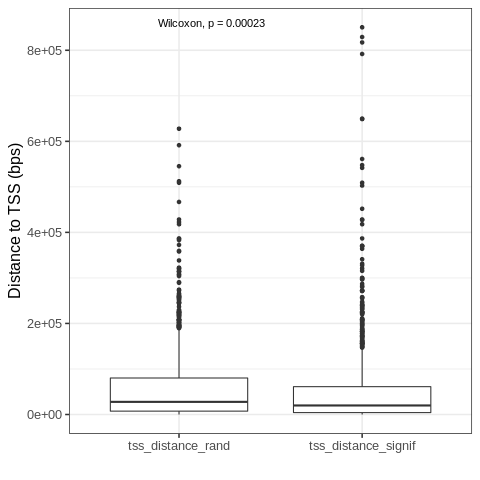

In [164]:
%%R
signif_cor_observed %>%
    pivot_longer(c("tss_distance_signif", "tss_distance_rand")) %>%
    ggplot(aes(name, value)) +
    geom_boxplot() +
    ggpubr::stat_compare_means() +
    theme_bw(base_size=16) +
    ylab("Distance to TSS (bps)") + xlab("")

---